In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from fff.evaluate.fid import compute_fid_openai_tf as compute_fid
import torch.nn as nn
import torch.optim as optim
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

INFO: Using pytorch backend
/home/hd/hd_hd/hd_gu452/miniconda3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2026-01-09 17:29:33.706535: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
class TemperatureScaler(nn.Module):
    """
    Applies temperature scaling to logits:
        scaled_logits = logits / T
    """
    def __init__(self):
        super().__init__()
        # Initialize T = 1
        self.log_temperature = nn.Parameter(torch.zeros(5, device=device))

    @property
    def temperature(self):
        return torch.exp(self.log_temperature)

    def forward(self, logits):
        return logits / self.temperature


@torch.no_grad()
def collect_logits_and_labels(model, dataloader, device):
    """
    Run model over dataloader and collect logits + labels.
    """
    all_logits = []
    all_labels = []
    model.eval()

    for x, y in dataloader:
        x = x.to(device)
        y = y.to(device)

        logits = model(x)
        all_logits.append(logits.cpu())
        all_labels.append(y.cpu())

    return torch.cat(all_logits, dim=0), torch.cat(all_labels, dim=0)


def fit_temperature_scaling(logits, labels, max_iter=50, lr=0.02):
    """
    Fits temperature T on validation logits using binary cross-entropy loss
    for multi-label classification.
    """
    scaler = TemperatureScaler()
    optimizer = optim.LBFGS([scaler.log_temperature], lr=lr, max_iter=max_iter)

    bce = nn.BCEWithLogitsLoss()

    def _eval():
        optimizer.zero_grad()
        scaled_logits = scaler(logits)
        loss = bce(scaled_logits, labels)
        loss.backward()
        return loss

    optimizer.step(_eval)
    return scaler


@torch.no_grad()
def compute_calibration(logits, labels):
    """
    Full wrapper:
    1. Collect logits + labels from dataloader
    2. Fit temperature scaling
    3. Return calibrated probabilities + temperature
    """
    # ---- Step 2: fit calibrator ----
    scaler = fit_temperature_scaling(logits, labels, max_iter=50)

    # ---- Step 3: compute calibrated probabilities ----
    calibrated_logits = scaler(logits)

    return calibrated_logits, scaler

@torch.no_grad()
def tune_threshold(logits, labels, metric="f1", num_thresholds=200):
    """
    logits: [N, C] unnormalized model outputs
    labels: [N, C] ground truth (0/1)
    metric: "f1", "precision", or "recall"
    """
    probs = torch.sigmoid(logits)

    # Candidate thresholds
    thresholds = torch.linspace(0, 1, num_thresholds)

    best_t = - torch.ones(5, device=device)
    best_score = - torch.ones(5, device=device)

    for t in thresholds:
        preds = (probs >= t).float()

        tp = (preds * labels).sum(dim=0)
        fp = ((preds == 1) & (labels == 0)).sum(dim=0)
        fn = ((preds == 0) & (labels == 1)).sum(dim=0)

        precision = tp / (tp + fp + 1e-12)
        recall = tp / (tp + fn + 1e-12)
        f1 = 2 * precision * recall / (precision + recall + 1e-12)
        # Mean over classes
        if metric == "precision":
            score = precision
        elif metric == "recall":
            score = recall
        else:
            score = f1
        new_best_ind = score > best_score
        best_t[new_best_ind] = t
        best_score[new_best_ind] = score[new_best_ind]

    return best_t, best_score


In [3]:
target_columns = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']
all_pathologies = [
            "No Finding",
            "Enlarged Cardiomediastinum",
            "Cardiomegaly",
            "Lung Opacity",
            "Lung Lesion",
            "Edema",
            "Consolidation",
            "Pneumonia",
            "Atelectasis",
            "Pneumothorax",
            "Pleural Effusion",
            "Pleural Other",
            "Fracture",
            "Support Devices",
        ]

target_indices = [all_pathologies.index(target) for target in target_columns]

In [4]:
@torch.no_grad()
def compute_ROC_curve(logits, targets, num_bins=10):
    fpr = []
    tpr = []
    reg_fpr = (~targets).sum() == 0
    reg_tpr = (targets).sum() == 0
    
    for threshold in torch.linspace(1, 0, num_bins):
        quantile = logits.quantile(threshold.to(logits.device))
        labels = logits > quantile      
        fpr.append((labels[~targets].sum()+reg_fpr)/((~targets).sum()+reg_fpr))
        tpr.append((labels[targets].sum()+reg_tpr)/(targets.sum()+reg_tpr))
    return torch.stack(fpr, dim=0), torch.stack(tpr, dim=0)

# Convnext vs. Biomedclip small head

# Convnext vs Biomedclip larger head

In [5]:
# invariance_dict = torch.load("/home/hd/hd_hd/hd_gu452/workspaces/gpfs/hd_gu452-chexpert/sampled_invariances/convnext_only/sampled_invariances_convnext_only.pt")
invariance_dict = torch.load("/home/hd/hd_hd/hd_gu452/FFF_fiberlearning/notebooks/CheXpert/sampled_invariances_12_11_20__06_01_2026_41905.pt")

In [6]:
invariances_convnext = invariance_dict["invariances_convnext"]
invariances_biomed = invariance_dict["invariances_biomed"]
originals = invariance_dict["originals"]
labels = invariance_dict["labels"]
invariances_convnext_embeddings = invariance_dict["invariances_convnext_embeddings"]
invariances_biomed_embeddings = invariance_dict["invariances_biomed_embeddings"]
original_convnext_embeddings = invariance_dict["original_convnext_embeddings"]
original_biomed_embeddings = invariance_dict["original_biomed_embeddings"]
invariances_convnext_cross_embeddings = invariance_dict["invariances_convnext_cross_embeddings"]
invariances_biomed_cross_embeddings = invariance_dict["invariances_biomed_cross_embeddings"]

labels = labels[:,target_indices]

In [7]:
original_convnext_embeddings_calibrated, scaler_convnext = compute_calibration(original_convnext_embeddings.to(device), labels.to(device))
original_biomed_embeddings_calibrated, scaler_biomed = compute_calibration(original_biomed_embeddings.to(device), labels.to(device))

threshold_convnext, f1_score_convnext = tune_threshold(original_convnext_embeddings_calibrated.to(device), labels.to(device))
threshold_biomed, f1_score_biomed = tune_threshold(original_biomed_embeddings_calibrated.to(device), labels.to(device))

In [8]:
invariances_convnext_embeddings_calibrated = scaler_convnext(invariances_convnext_embeddings)
invariances_biomed_embeddings_calibrated = scaler_biomed(invariances_biomed_embeddings)
invariances_convnext_cross_embeddings_calibrated = scaler_biomed(invariances_convnext_cross_embeddings)
invariances_biomed_cross_embeddings_calibrated = scaler_convnext(invariances_biomed_cross_embeddings)

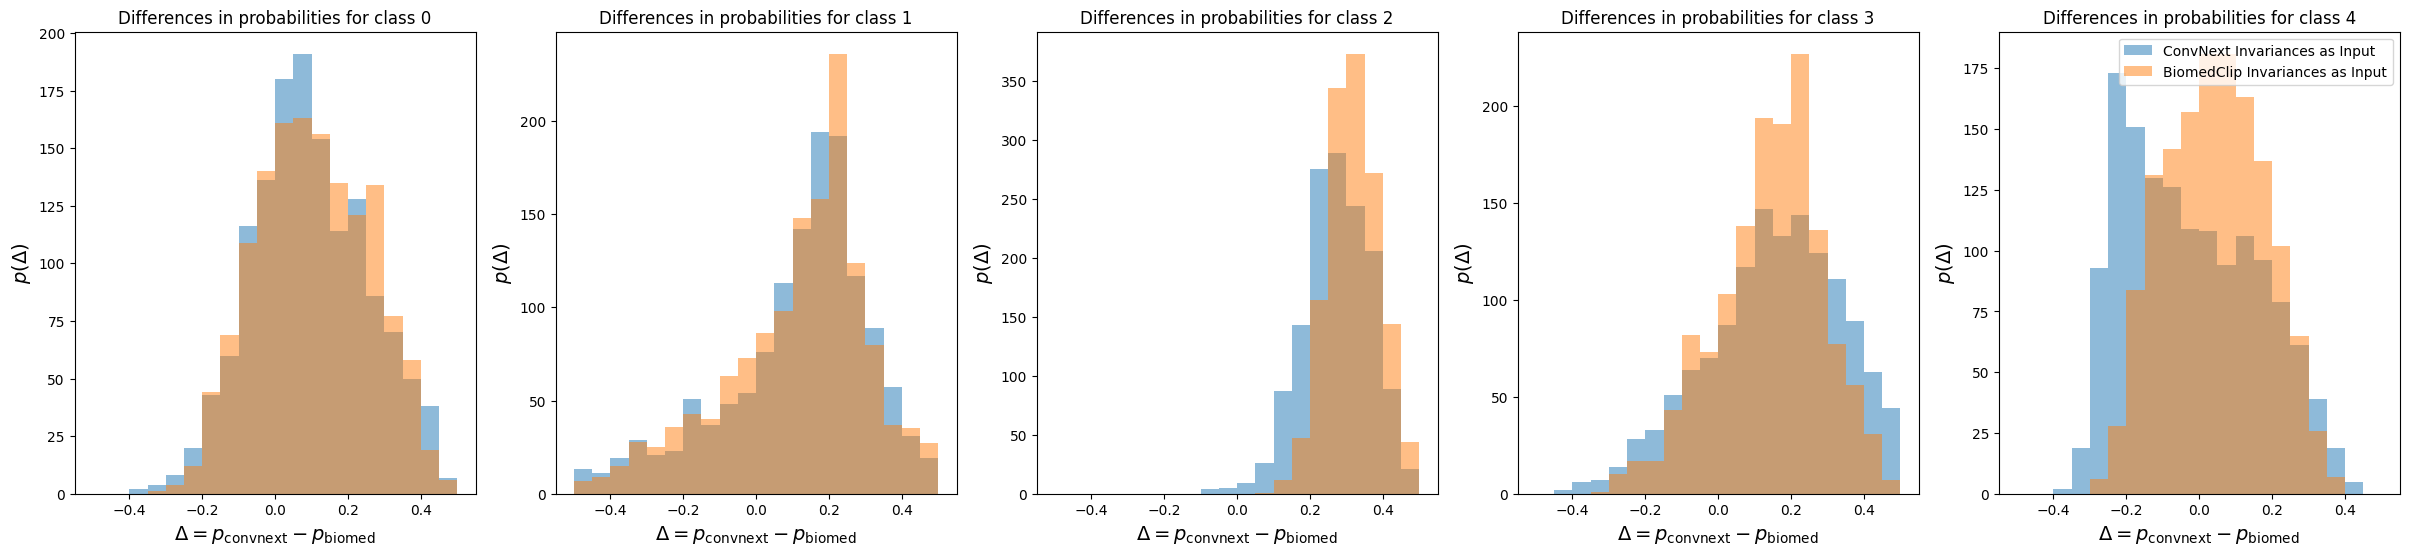

In [9]:
difference_convnext_embeddings = invariances_convnext_embeddings_calibrated.sigmoid() - invariances_convnext_cross_embeddings_calibrated.sigmoid()
difference_biomed_embeddings = invariances_biomed_cross_embeddings_calibrated.sigmoid() - invariances_biomed_embeddings_calibrated.sigmoid()
plt.figure(figsize=(6*difference_convnext_embeddings.shape[1], 6))
plt.tight_layout()
for i in range(difference_convnext_embeddings.shape[1]):
    plt.subplot(1, difference_convnext_embeddings.shape[1], i+1)
    plt.title(f"Differences in probabilities for class {i}")
    plt.hist(difference_convnext_embeddings[:,i].cpu().detach().numpy(), range=[-0.5, 0.5], bins=20, density=False, alpha=0.5, label="ConvNext Invariances as Input")
    plt.hist(difference_biomed_embeddings[:,i].cpu().detach().numpy(), range=[-0.5, 0.5], bins=20, density=False, alpha=0.5, label="BiomedClip Invariances as Input")
    plt.ylabel(r"$p(\Delta)$", fontsize=14)
    plt.xlabel(r"$\Delta = p_\text{convnext} - p_\text{biomed}$", fontsize=14)
plt.legend()
plt.show()

In [26]:
aurocs = {
    "convnext_originals": torch.zeros(5),
    "biomed_originals": torch.zeros(5),
    "convnext_relabeled": torch.zeros(5),
    "biomed_relabeled": torch.zeros(5),
    "convnext_cross_labeled": torch.zeros(5),
    "biomed_cross_labeled": torch.zeros(5),
    "convnext_same_labeled": torch.zeros(5),
    "biomed_same_labeled": torch.zeros(5),
    "convnext_cross_agreement": torch.zeros(5),
    "biomed_cross_agreement": torch.zeros(5),
}

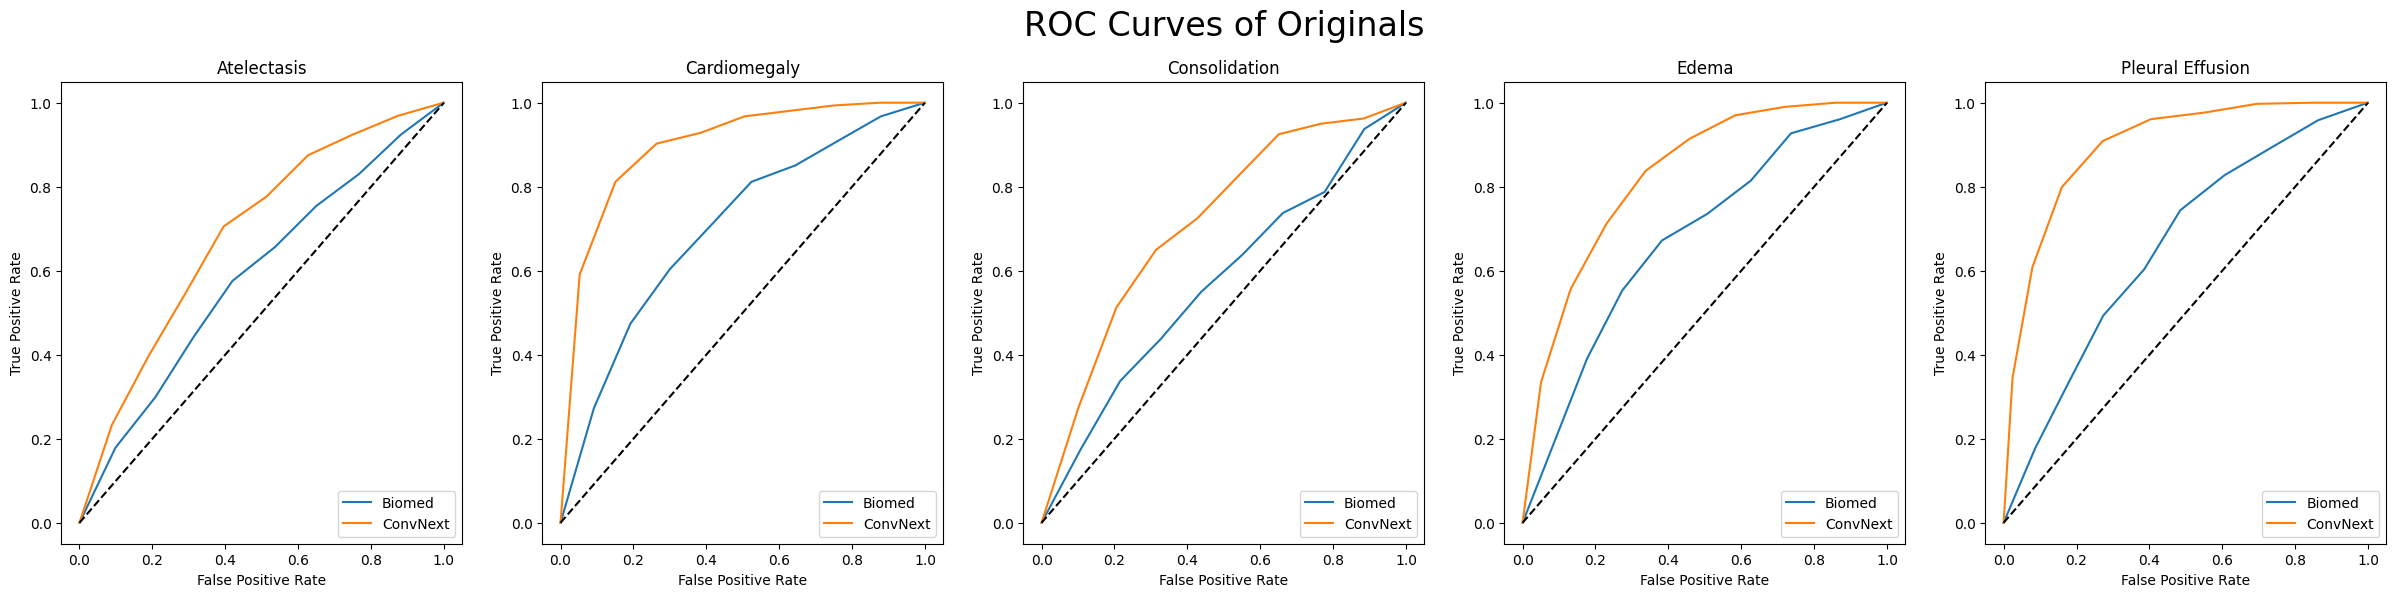

In [27]:
plt.figure(figsize=(6*original_convnext_embeddings_calibrated.shape[1], 6))
plt.tight_layout()
plt.title("ROC Curves of Originals\n", fontsize=24)
plt.axis("off")



for i in range(original_convnext_embeddings_calibrated.shape[1]):
    plt.subplot(1, original_convnext_embeddings_calibrated.shape[1], i+1)
    fpr, tpr = compute_ROC_curve(original_biomed_embeddings_calibrated[:,i], labels[:,i].bool())
    aurocs["biomed_originals"][i] = torch.trapz(tpr, fpr)
    plt.plot(fpr.cpu().detach().numpy(), tpr.cpu().detach().numpy(), label="Biomed")
    fpr, tpr = compute_ROC_curve(original_convnext_embeddings_calibrated[:,i], labels[:,i].bool())
    aurocs["convnext_originals"][i] = torch.trapz(tpr, fpr)
    plt.plot(fpr.cpu().detach().numpy(), tpr.cpu().detach().numpy(), label="ConvNext")
    plt.plot([0, 1], [0, 1], color="black", linestyle="--")
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc="lower right")
    plt.title(target_columns[i])
plt.show()

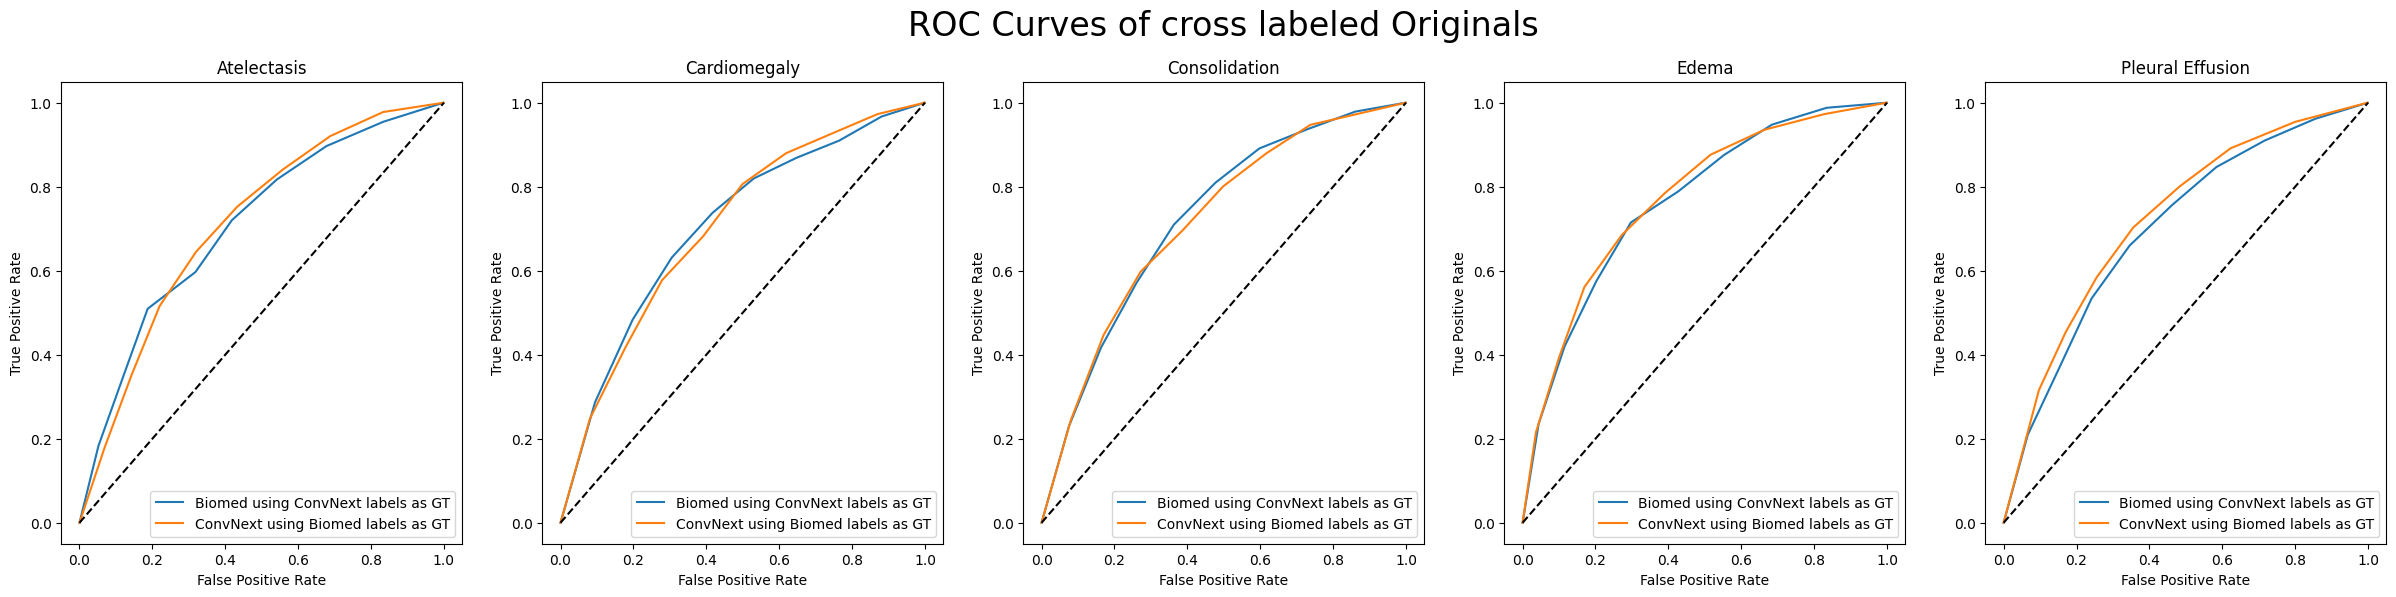

In [28]:
originals_labeled_by_convnext = original_convnext_embeddings_calibrated.sigmoid() > threshold_convnext
originals_labeled_by_biomed = original_biomed_embeddings_calibrated.sigmoid() > threshold_biomed
plt.figure(figsize=(6*original_convnext_embeddings.shape[1], 6))
plt.tight_layout()
plt.title("ROC Curves of cross labeled Originals\n", fontsize=24)
plt.axis("off")

for i in range(original_convnext_embeddings_calibrated.shape[1]):
    plt.subplot(1, original_convnext_embeddings_calibrated.shape[1], i+1)
    fpr, tpr = compute_ROC_curve(original_biomed_embeddings_calibrated[:,i], originals_labeled_by_convnext[:,i])
    aurocs["biomed_relabeled"][i] = torch.trapz(tpr, fpr)
    plt.plot(fpr.cpu().detach().numpy(), tpr.cpu().detach().numpy(), label="Biomed using ConvNext labels as GT")
    fpr, tpr = compute_ROC_curve(original_convnext_embeddings_calibrated[:,i], originals_labeled_by_biomed[:,i])
    aurocs["convnext_relabeled"][i] = torch.trapz(tpr, fpr)
    plt.plot(fpr.cpu().detach().numpy(), tpr.cpu().detach().numpy(), label="ConvNext using Biomed labels as GT")
    plt.plot([0, 1], [0, 1], color="black", linestyle="--")
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc="lower right")
    plt.title(target_columns[i])
plt.show()

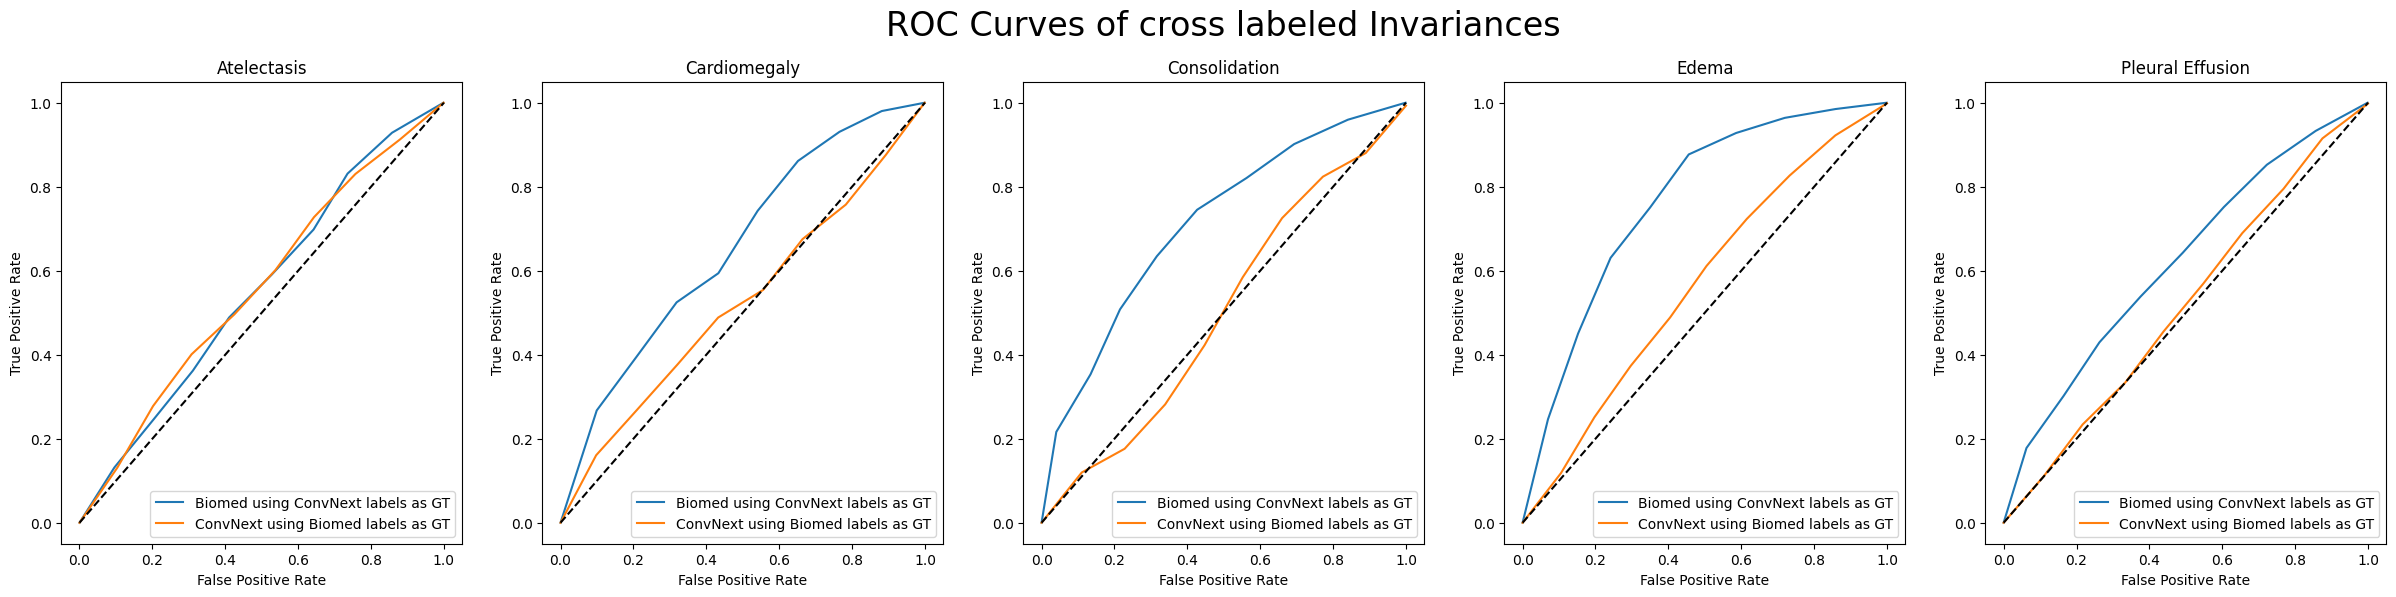

In [34]:
invariances_cross_labeled_by_convnext = invariances_biomed_cross_embeddings_calibrated.sigmoid() > threshold_convnext
invariances_cross_labeled_by_biomed = invariances_convnext_cross_embeddings_calibrated.sigmoid() > threshold_biomed
plt.figure(figsize=(6*invariances_biomed_embeddings.shape[1], 6))
plt.tight_layout()
plt.title("ROC Curves of cross labeled Invariances\n", fontsize=24)
plt.axis("off")

for i in range(invariances_biomed_embeddings_calibrated.shape[1]):
    plt.subplot(1, invariances_biomed_embeddings_calibrated.shape[1], i+1)
    fpr, tpr = compute_ROC_curve(invariances_biomed_embeddings_calibrated[:,i], invariances_cross_labeled_by_convnext[:,i])
    aurocs["biomed_cross_labeled"][i] = torch.trapz(tpr, fpr)
    plt.plot(fpr.cpu().detach().numpy(), tpr.cpu().detach().numpy(), label="Biomed using ConvNext labels as GT")
    fpr, tpr = compute_ROC_curve(invariances_convnext_embeddings_calibrated[:,i], invariances_cross_labeled_by_biomed[:,i])
    aurocs["convnext_cross_labeled"][i] = torch.trapz(tpr, fpr)
    plt.plot(fpr.cpu().detach().numpy(), tpr.cpu().detach().numpy(), label="ConvNext using Biomed labels as GT")
    plt.plot([0, 1], [0, 1], color="black", linestyle="--")
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc="lower right")
    plt.title(target_columns[i])
plt.show()

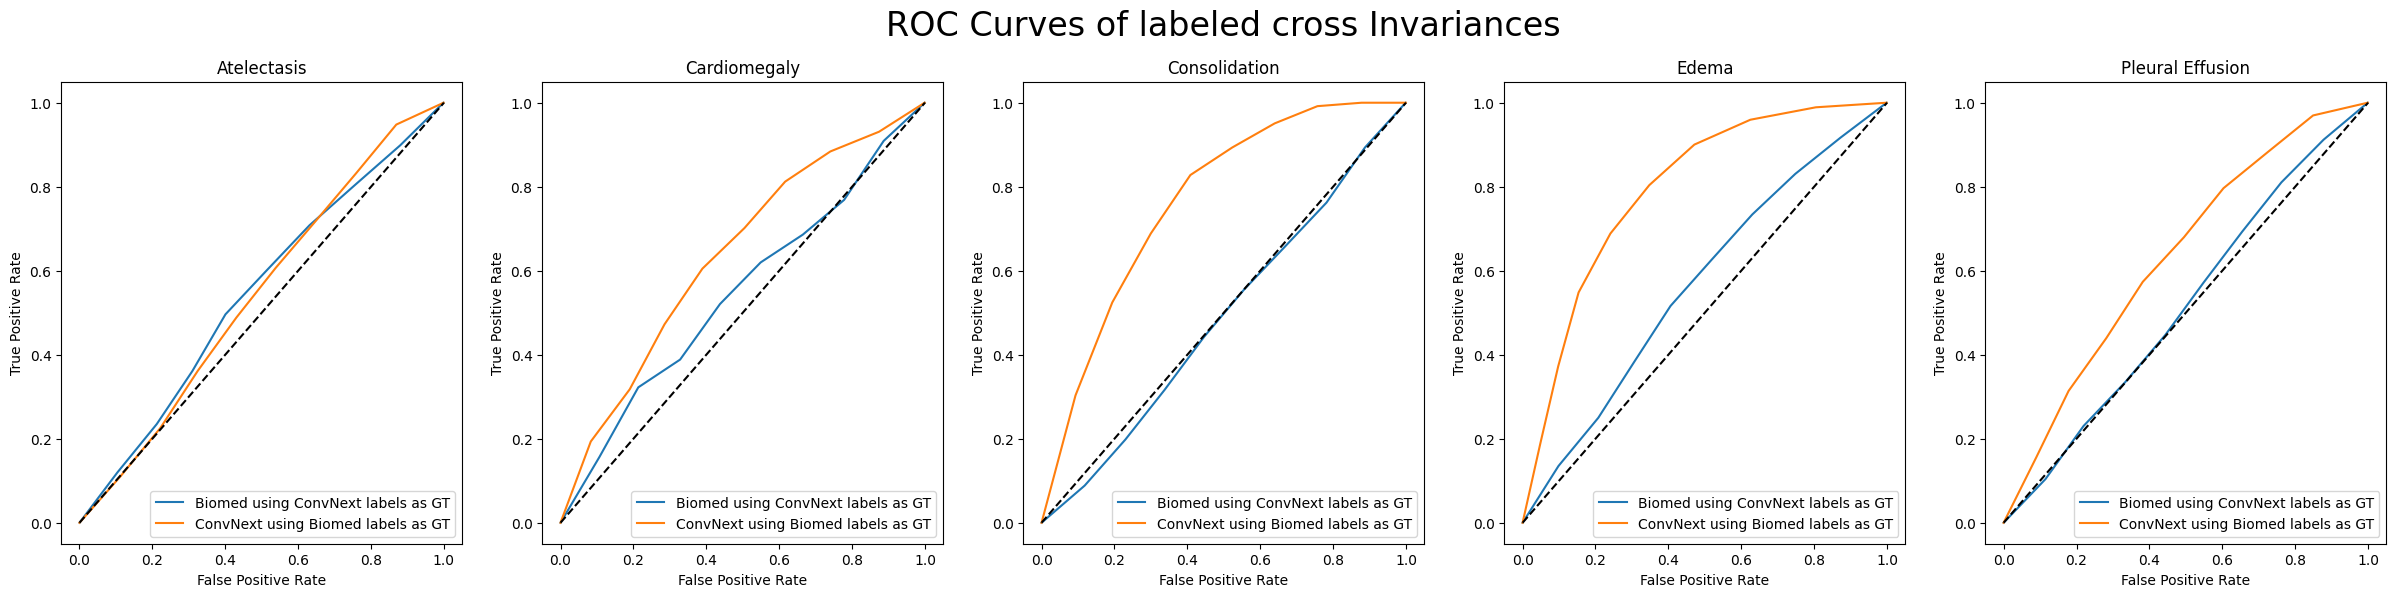

In [35]:
invariances_labeled_by_convnext = invariances_convnext_embeddings_calibrated.sigmoid() > threshold_convnext
invariances_labeled_by_biomed = invariances_biomed_embeddings_calibrated.sigmoid() > threshold_biomed
plt.figure(figsize=(6*invariances_biomed_embeddings.shape[1], 6))
plt.tight_layout()
plt.title("ROC Curves of labeled cross Invariances\n", fontsize=24)
plt.axis("off")

for i in range(invariances_biomed_embeddings_calibrated.shape[1]):
    plt.subplot(1, invariances_biomed_embeddings_calibrated.shape[1], i+1)
    fpr, tpr = compute_ROC_curve(invariances_convnext_cross_embeddings_calibrated[:,i], invariances_labeled_by_convnext[:,i])
    aurocs["biomed_same_labeled"][i] = torch.trapz(tpr, fpr)
    plt.plot(fpr.cpu().detach().numpy(), tpr.cpu().detach().numpy(), label="Biomed using ConvNext labels as GT")
    fpr, tpr = compute_ROC_curve(invariances_biomed_cross_embeddings_calibrated[:,i], invariances_labeled_by_biomed[:,i])
    aurocs["convnext_same_labeled"][i] = torch.trapz(tpr, fpr)
    plt.plot(fpr.cpu().detach().numpy(), tpr.cpu().detach().numpy(), label="ConvNext using Biomed labels as GT")
    plt.plot([0, 1], [0, 1], color="black", linestyle="--")
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc="lower right")
    plt.title(target_columns[i])
plt.show()

In [36]:
df = pd.DataFrame(aurocs).T
df.columns = [target_columns[i] for i in range(df.shape[1])]

df# .to_latex(float_format="{:.2f}".format, index=False,)

Atelectasis  Cardiomegaly  Consolidation     Edema  \
convnext_originals           0.687764      0.895091       0.714098  0.826171   
biomed_originals             0.586417      0.698352       0.569915  0.675509   
convnext_relabeled           0.712000      0.704595       0.716262  0.770636   
biomed_relabeled             0.707148      0.706493       0.723096  0.764014   
convnext_cross_labeled       0.557009      0.521457       0.501350  0.566533   
biomed_cross_labeled         0.553539      0.654407       0.710864  0.765371   
convnext_same_labeled        0.542047      0.636095       0.764265  0.794009   
biomed_same_labeled          0.545004      0.544438       0.486769  0.565951   
convnext_cross_agreement     0.000000      0.000000       0.000000  0.000000   
biomed_cross_agreement       0.000000      0.000000       0.000000  0.000000   

                          Pleural Effusion  
convnext_originals                0.894680  
biomed_originals                  0.656671  
convnext_relabeled                0.723650  
biomed_relabeled                  0.701584  
convnext_cross_labeled            0.517362  
biomed_cross_labeled              0.619527  
convnext_same_labeled             0.633024  
biomed_same_labeled               0.515459  
convnext_cross_agreement          0.000000  
biomed_cross_agreement            0.000000

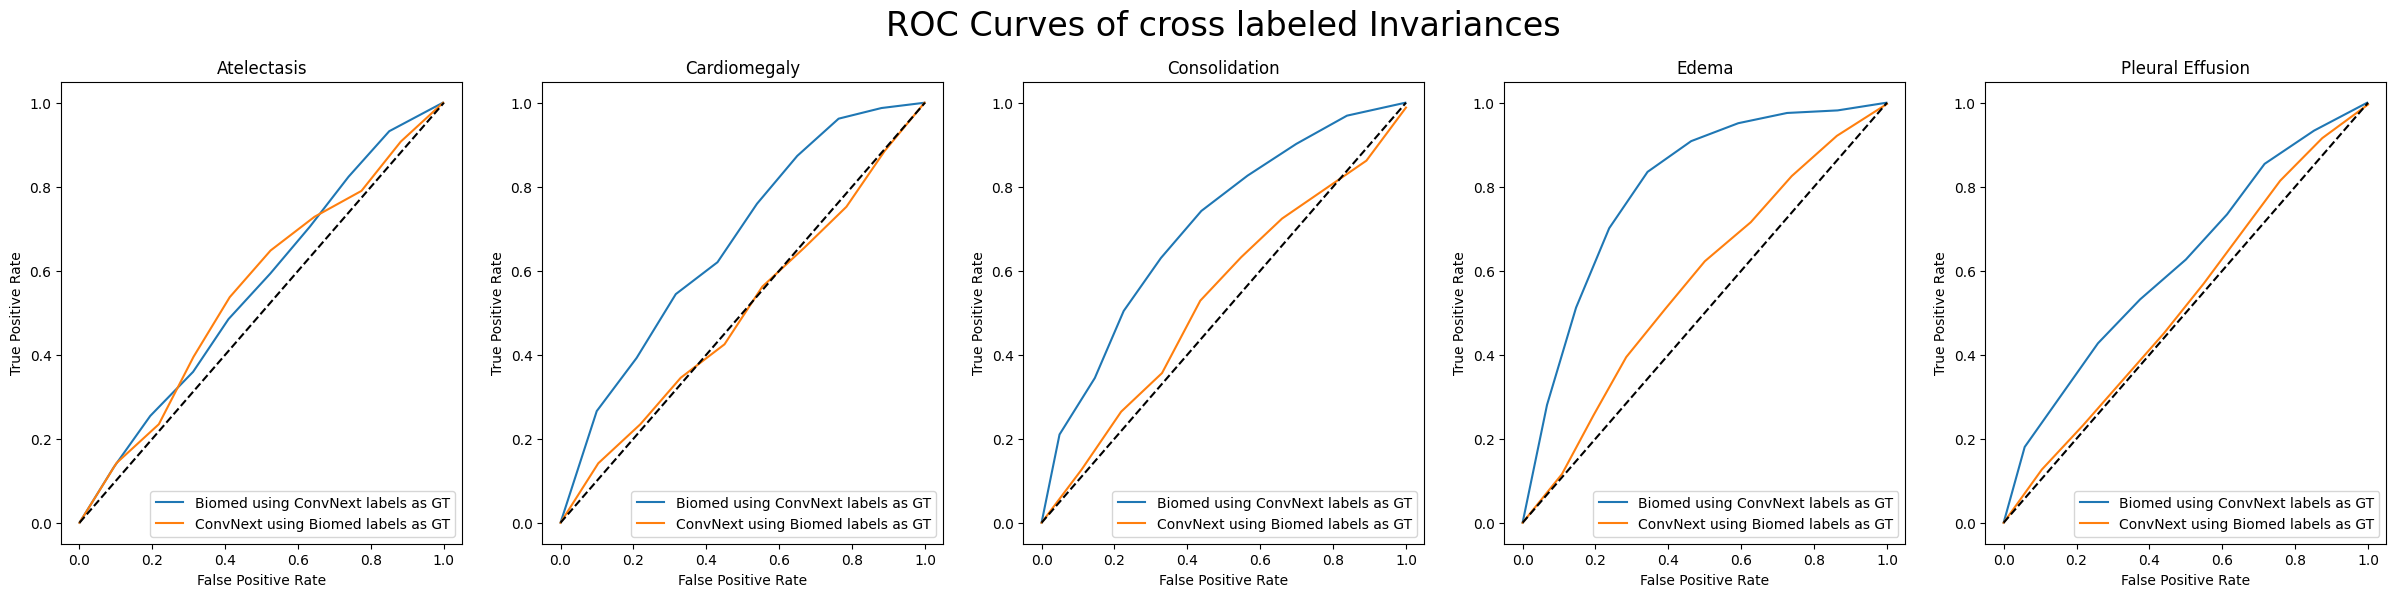

In [52]:
biomed_correct = (original_biomed_embeddings_calibrated.sigmoid() > threshold_biomed).to(device) == labels.to(device)
convnext_correct = (original_convnext_embeddings_calibrated.sigmoid() > threshold_convnext).to(device) == labels.to(device)

both_models_correct = torch.logical_and(biomed_correct, convnext_correct)

invariances_cross_labeled_by_convnext = invariances_biomed_cross_embeddings_calibrated.sigmoid() > threshold_convnext
invariances_cross_labeled_by_biomed = invariances_convnext_cross_embeddings_calibrated.sigmoid() > threshold_biomed


plt.figure(figsize=(6*invariances_biomed_embeddings.shape[1], 6))
plt.tight_layout()
plt.title("ROC Curves of cross labeled Invariances\n", fontsize=24)
plt.axis("off")

agreement_on_biomed_invariances = torch.zeros(5)
agreement_on_convnext_invariances = torch.zeros(5)
agreement_on_originals = ((original_biomed_embeddings_calibrated.sigmoid() > threshold_biomed) == (original_convnext_embeddings_calibrated.sigmoid() > threshold_convnext)).float().mean(dim=0)


for i in range(invariances_biomed_embeddings_calibrated.shape[1]):
    plt.subplot(1, invariances_biomed_embeddings_calibrated.shape[1], i+1)
    fpr, tpr = compute_ROC_curve(invariances_biomed_embeddings_calibrated[both_models_correct[:, i],i], invariances_cross_labeled_by_convnext[both_models_correct[:, i],i])
    aurocs["biomed_cross_agreement"][i] = torch.trapz(tpr, fpr)
    agreement_on_biomed_invariances[i] = (invariances_cross_labeled_by_convnext[both_models_correct[:, i],i] == labels.to(device)[both_models_correct[:, i],i]).float().mean()
    plt.plot(fpr.cpu().detach().numpy(), tpr.cpu().detach().numpy(), label="Biomed using ConvNext labels as GT")    

    
    fpr, tpr = compute_ROC_curve(invariances_convnext_embeddings_calibrated[both_models_correct[:, i],i], invariances_cross_labeled_by_biomed[both_models_correct[:, i],i])
    aurocs["convnext_cross_agreement"][i] = torch.trapz(tpr, fpr)
    agreement_on_convnext_invariances[i] = (invariances_cross_labeled_by_biomed[both_models_correct[:, i],i] == labels.to(device)[both_models_correct[:, i],i]).float().mean()
    plt.plot(fpr.cpu().detach().numpy(), tpr.cpu().detach().numpy(), label="ConvNext using Biomed labels as GT")
    plt.plot([0, 1], [0, 1], color="black", linestyle="--")
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc="lower right")
    plt.title(target_columns[i])
plt.show()

In [54]:
print(agreement_on_biomed_invariances)
print(agreement_on_convnext_invariances)
print(agreement_on_originals)

print(agreement_on_biomed_invariances.mean())
print(agreement_on_convnext_invariances.mean())
print(agreement_on_originals.mean())

tensor([0.5150, 0.8949, 0.6097, 0.6625, 0.4678])
tensor([0.6866, 0.7786, 0.8865, 0.5626, 0.5588])
tensor([0.6645, 0.8057, 0.7525, 0.7163, 0.6050], device='cuda:0')
tensor(0.6300)
tensor(0.6946)
tensor(0.7088, device='cuda:0')


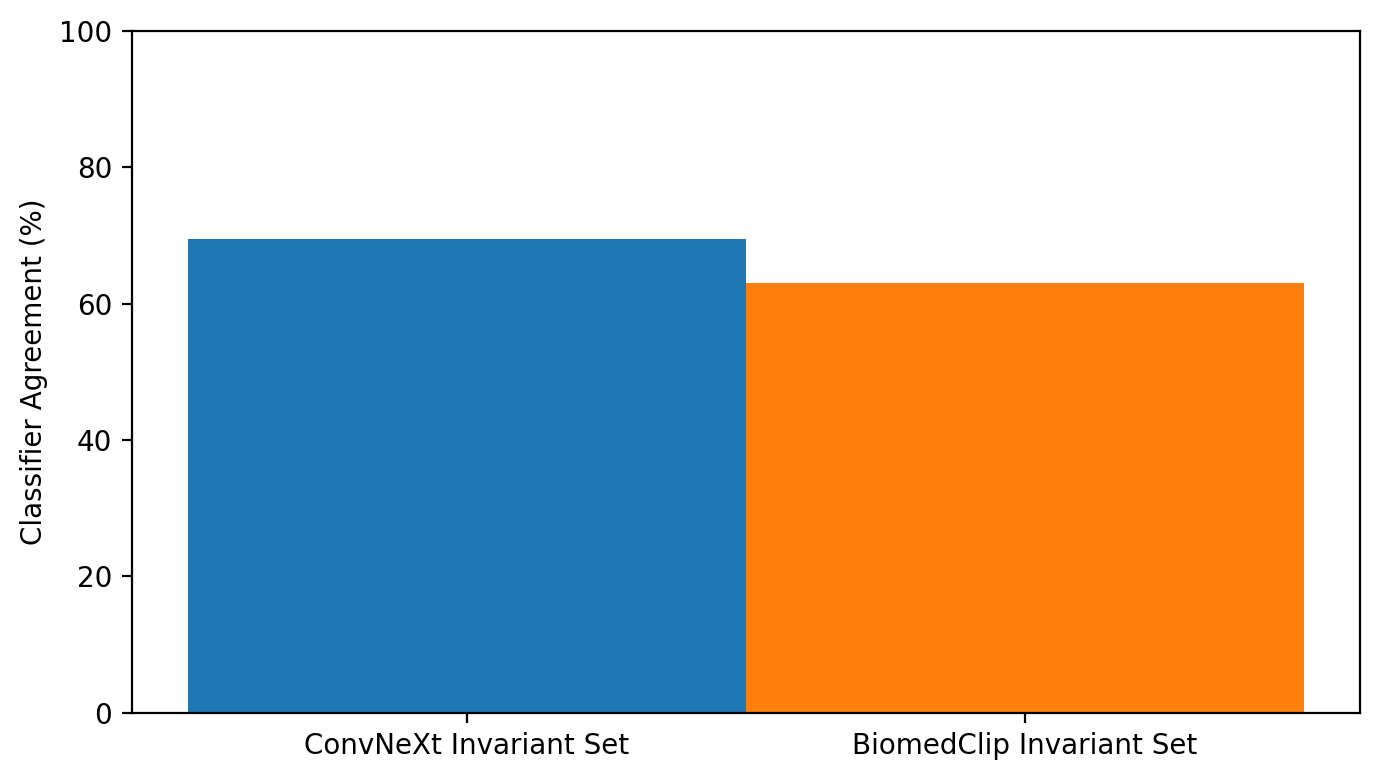

In [81]:
agreement_marg_orig = agreement_on_originals.mean().item()
agreement_marg_convnext = agreement_on_convnext_invariances.mean().item()*100
agreement_marg_biomed = agreement_on_biomed_invariances.mean().item()*100

labels = ["ConvNeXt Invariant Set", "BiomedClip Invariant Set"]
x = np.arange(len(labels))
width = 1

plt.figure(figsize=(7, 4), dpi=200)

plt.bar(
    x,
    [agreement_marg_convnext, agreement_marg_biomed],
    width,
    color=["C0", "C1"],
    capsize=4,
)


plt.xticks(x, labels)
plt.ylabel("Classifier Agreement (%)")
plt.ylim(0, 100)
plt.tight_layout()
plt.show()


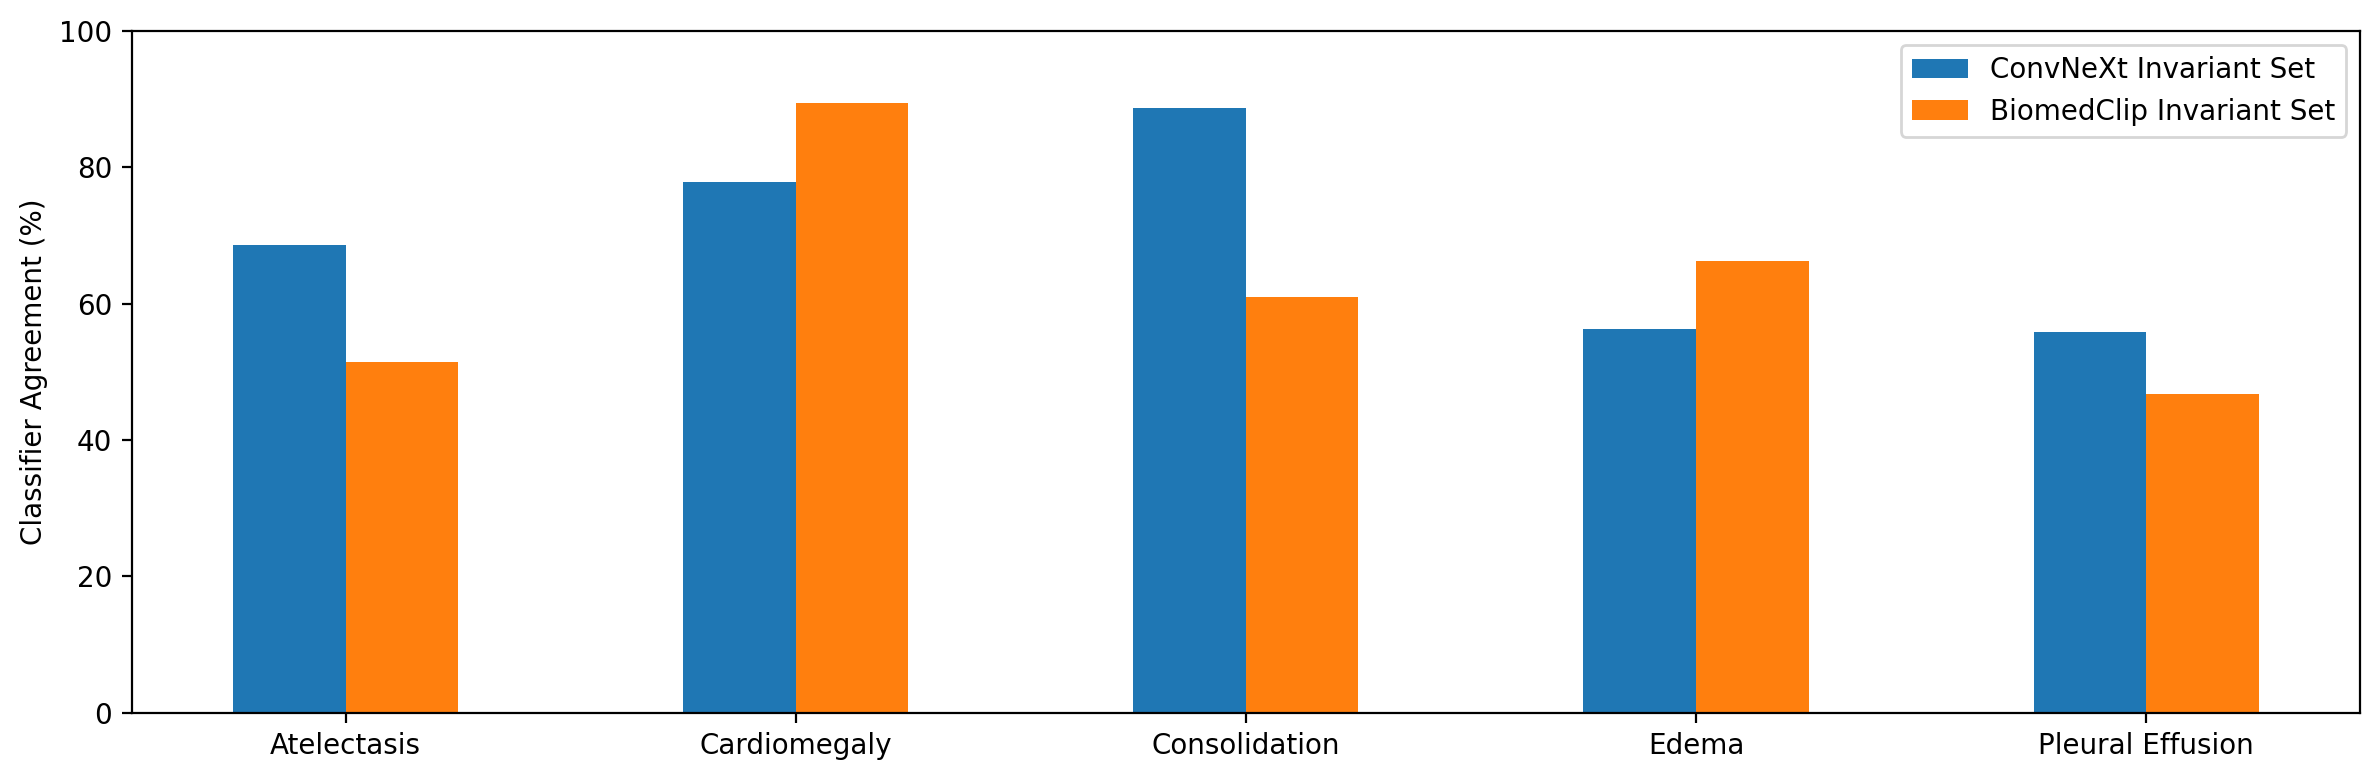

In [83]:
labels = target_columns
x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(12, 4), dpi=200)

# plt.bar(
#     x - width,
#     agreement_on_originals.cpu().detach().numpy()*100,
#     width,
#     label="Original Samples",
#     capsize=4,
# )

plt.bar(
    x - width/2,
    agreement_on_convnext_invariances.cpu().detach().numpy()*100,
    width,
    label="ConvNeXt Invariant Set",
    capsize=4,
)

plt.bar(
    x + width/2,
    agreement_on_biomed_invariances.cpu().detach().numpy()*100,
    width,
    label="BiomedClip Invariant Set",
    capsize=4,
)


plt.xticks(x, labels)
plt.ylabel("Classifier Agreement (%)")
plt.ylim(0, 100)
plt.legend()
plt.tight_layout()
plt.show()

In [38]:
df = pd.DataFrame(aurocs).T
df.columns = [target_columns[i] for i in range(df.shape[1])]

df

Atelectasis  Cardiomegaly  Consolidation     Edema  \
convnext_originals           0.687764      0.895091       0.714098  0.826171   
biomed_originals             0.586417      0.698352       0.569915  0.675509   
convnext_relabeled           0.712000      0.704595       0.716262  0.770636   
biomed_relabeled             0.707148      0.706493       0.723096  0.764014   
convnext_cross_labeled       0.557009      0.521457       0.501350  0.566533   
biomed_cross_labeled         0.553539      0.654407       0.710864  0.765371   
convnext_same_labeled        0.542047      0.636095       0.764265  0.794009   
biomed_same_labeled          0.545004      0.544438       0.486769  0.565951   
convnext_cross_agreement     0.555027      0.499010       0.534709  0.572429   
biomed_cross_agreement       0.556201      0.667505       0.702603  0.799067   

                          Pleural Effusion  
convnext_originals                0.894680  
biomed_originals                  0.656671  
convnext_relabeled                0.723650  
biomed_relabeled                  0.701584  
convnext_cross_labeled            0.517362  
biomed_cross_labeled              0.619527  
convnext_same_labeled             0.633024  
biomed_same_labeled               0.515459  
convnext_cross_agreement          0.523561  
biomed_cross_agreement            0.615375

In [60]:
invariances_cross_labeled_by_convnext = invariances_biomed_cross_embeddings_calibrated.sigmoid() > threshold_convnext
invariances_labeled_by_biomed = invariances_biomed_embeddings_calibrated.sigmoid() > threshold_biomed
original_labeled_by_biomed = original_biomed_embeddings_calibrated.sigmoid() > threshold_biomed
biomed_correct = (original_biomed_embeddings_calibrated.sigmoid() > threshold_biomed).to(device) == labels.to(device)
class_ind = 1
no_disease_seen = torch.logical_and(biomed_correct[:,class_ind], labels.to(device)[:,class_ind]==0)
disease_overlooked = torch.logical_and(no_disease_seen, invariances_cross_labeled_by_convnext[:,class_ind])
disease_overlooked = torch.logical_and(disease_overlooked, invariances_labeled_by_biomed[:,class_ind]==0)
print(sum(disease_overlooked))

tensor(43, device='cuda:0')


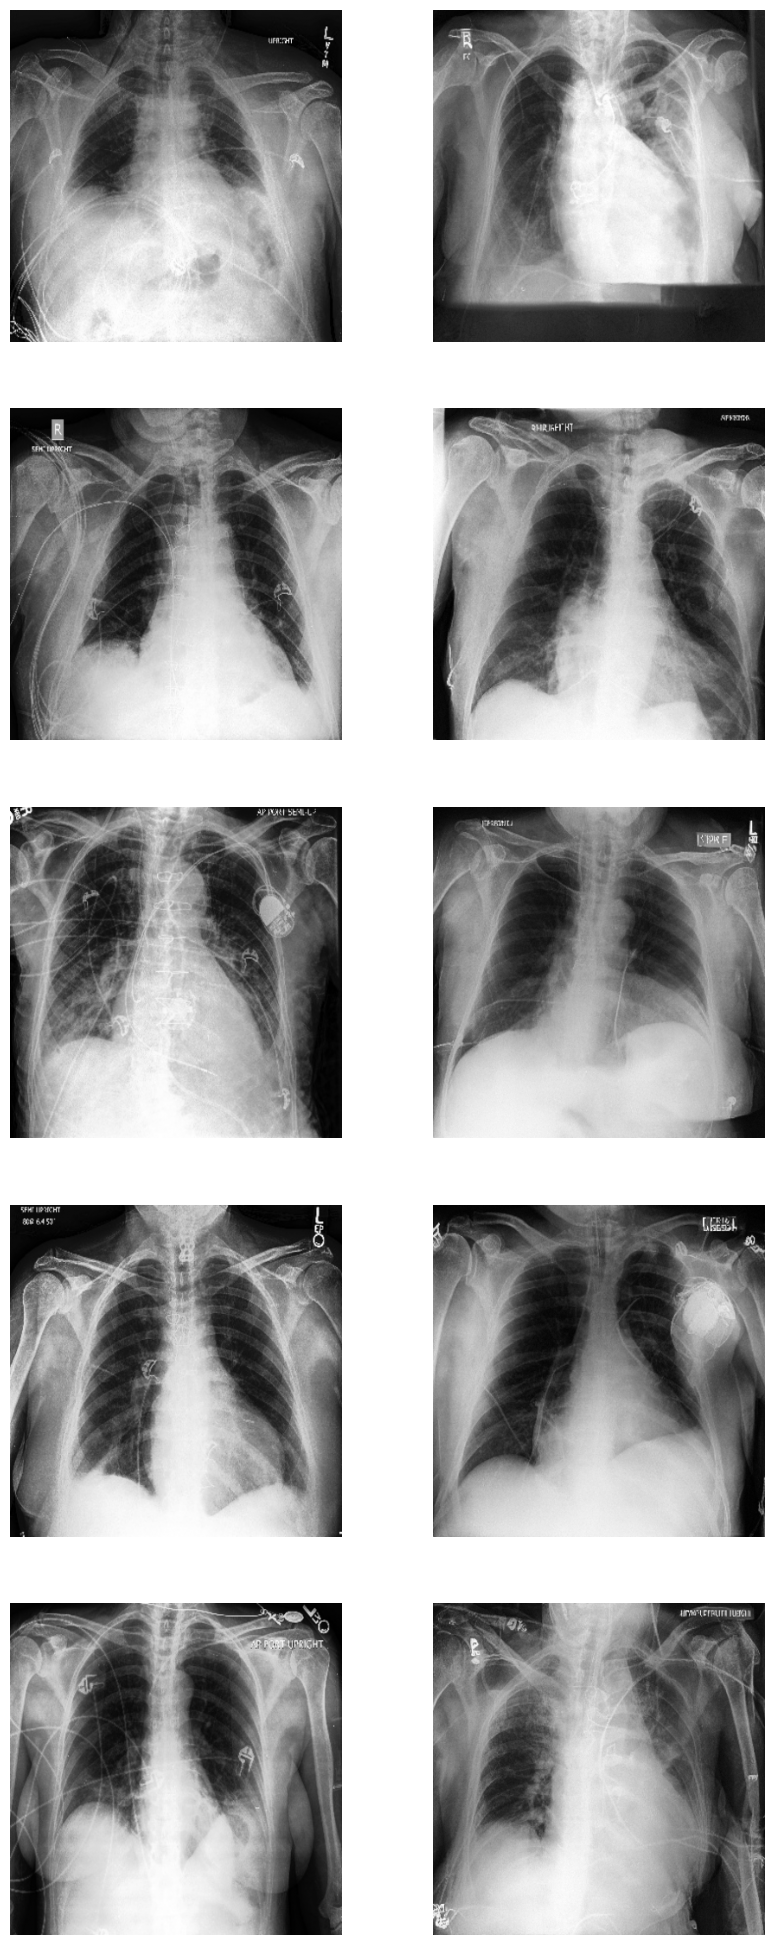

In [31]:
ind_disease_overlooked = torch.where(disease_overlooked)[0]
plt.figure(figsize=(10, 25))
for i, ind in enumerate(ind_disease_overlooked[torch.randperm(len(ind_disease_overlooked))[:5]]):
    plt.subplot(5, 2, i*2+1)
    plt.imshow(originals[ind].squeeze().cpu().detach().numpy(), cmap="gray")
    plt.axis("off")
    plt.subplot(5, 2, i*2+2)
    plt.imshow(invariances_biomed[ind].squeeze().cpu().detach().numpy(), cmap="gray")
    plt.axis("off")
plt.show()

In [32]:
invariances_cross_labeled_by_biomed = invariances_convnext_cross_embeddings_calibrated.sigmoid() > threshold_convnext
invariances_labeled_by_convnext = invariances_convnext_embeddings_calibrated.sigmoid() > threshold_biomed
original_labeled_by_convnext = original_convnext_embeddings_calibrated.sigmoid() > threshold_convnext
convnext_correct = (original_convnext_embeddings_calibrated.sigmoid() > threshold_convnext).to(device) == labels.to(device)
class_ind = 1
no_disease_seen = torch.logical_and(convnext_correct[:,class_ind], labels.to(device)[:,class_ind]==0)
disease_overlooked = torch.logical_and(no_disease_seen, invariances_cross_labeled_by_biomed[:,class_ind])
disease_overlooked = torch.logical_and(disease_overlooked, invariances_labeled_by_convnext[:,class_ind]==0)
print(sum(disease_overlooked))

tensor(73, device='cuda:0')


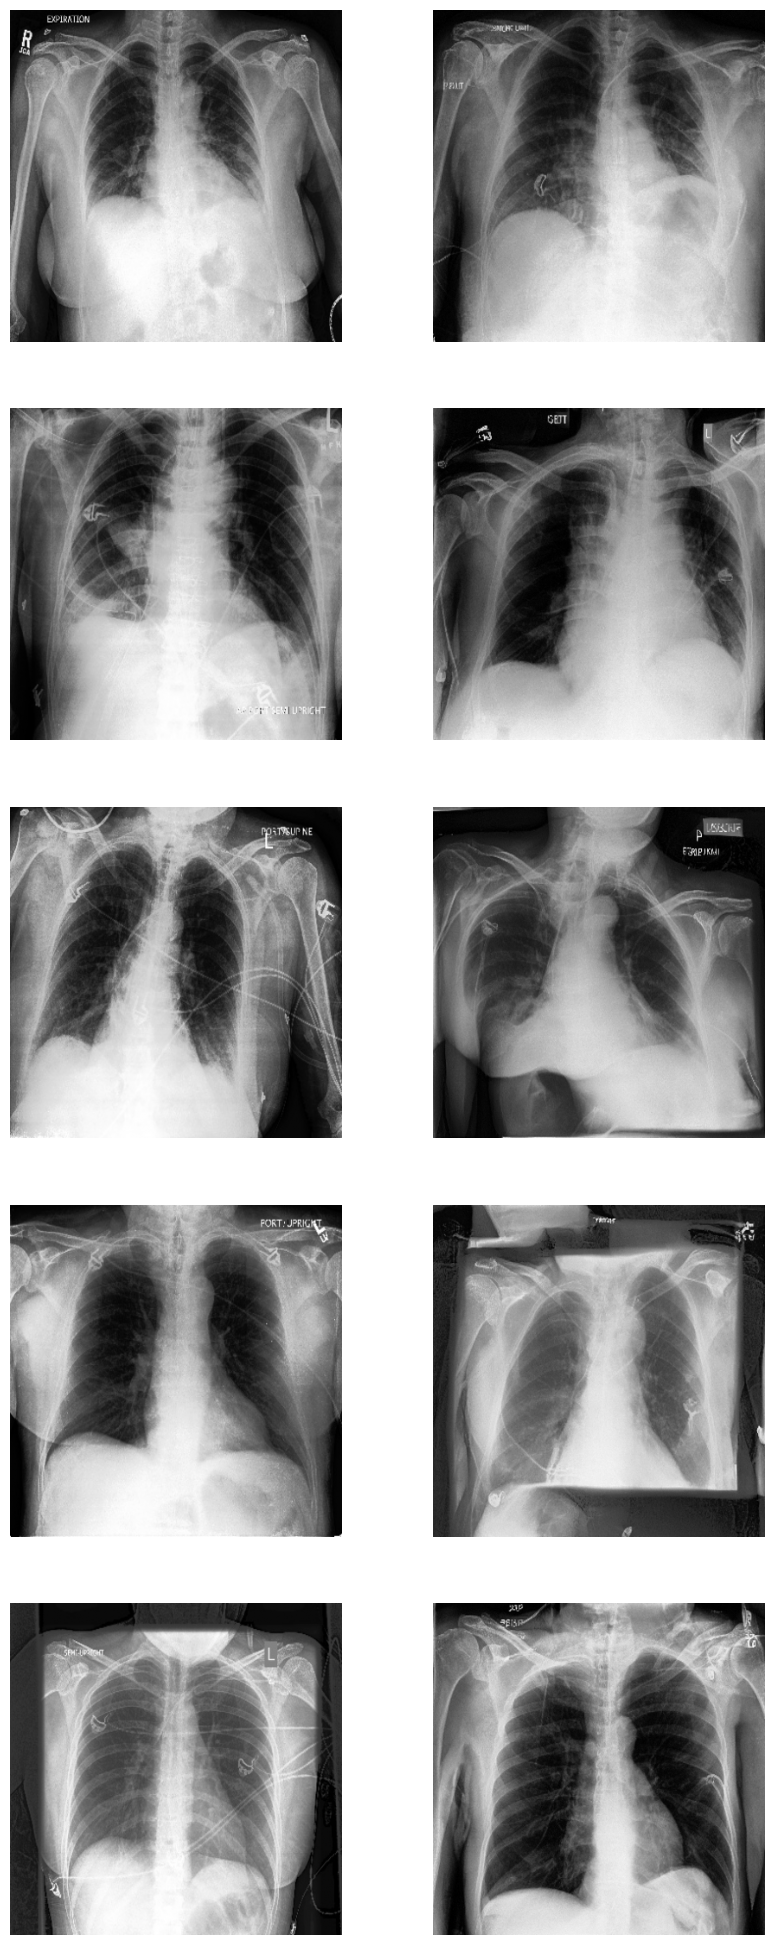

In [33]:
ind_disease_overlooked = torch.where(disease_overlooked)[0]
plt.figure(figsize=(10, 25))
for i, ind in enumerate(ind_disease_overlooked[torch.randperm(len(ind_disease_overlooked))[:5]]):
    plt.subplot(5, 2, i*2+1)
    plt.imshow(originals[ind].squeeze().cpu().detach().numpy(), cmap="gray")
    plt.axis("off")
    plt.subplot(5, 2, i*2+2)
    plt.imshow(invariances_biomed[ind].squeeze().cpu().detach().numpy(), cmap="gray")
    plt.axis("off")
plt.show()

# Convnext vs. Convnext

In [84]:
# invariance_dict = torch.load("/home/hd/hd_hd/hd_gu452/workspaces/gpfs/hd_gu452-chexpert/sampled_invariances/convnext_only/sampled_invariances_convnext_only.pt")
invariance_dict = torch.load("/home/hd/hd_hd/hd_gu452/FFF_fiberlearning/notebooks/CheXpert/sampled_invariances_same_12_15_09__06_01_2026_41905.pt")

In [85]:
invariances_convnext = invariance_dict["invariances_convnext"]
invariances_biomed = invariance_dict["invariances_convnext_2"]
originals = invariance_dict["originals"]
labels = invariance_dict["labels"]
invariances_convnext_embeddings = invariance_dict["invariances_convnext_embeddings"]
invariances_biomed_embeddings = invariance_dict["invariances_convnext_2_embeddings"]
original_convnext_embeddings = invariance_dict["original_convnext_embeddings"]
original_biomed_embeddings = invariance_dict["original_convnext_2_embeddings"]
invariances_convnext_cross_embeddings = invariance_dict["invariances_convnext_cross_embeddings"]
invariances_biomed_cross_embeddings = invariance_dict["invariances_convnext_2_cross_embeddings"]

labels = labels[:,target_indices]

In [86]:
original_convnext_embeddings_calibrated, scaler_convnext = compute_calibration(original_convnext_embeddings.to(device), labels.to(device))
original_biomed_embeddings_calibrated, scaler_biomed = compute_calibration(original_biomed_embeddings.to(device), labels.to(device))

threshold_convnext, f1_score_convnext = tune_threshold(original_convnext_embeddings_calibrated.to(device), labels.to(device))
threshold_biomed, f1_score_biomed = tune_threshold(original_biomed_embeddings_calibrated.to(device), labels.to(device))

In [87]:
invariances_convnext_embeddings_calibrated = scaler_convnext(invariances_convnext_embeddings)
invariances_biomed_embeddings_calibrated = scaler_biomed(invariances_biomed_embeddings)
invariances_convnext_cross_embeddings_calibrated = scaler_biomed(invariances_convnext_cross_embeddings)
invariances_biomed_cross_embeddings_calibrated = scaler_convnext(invariances_biomed_cross_embeddings)

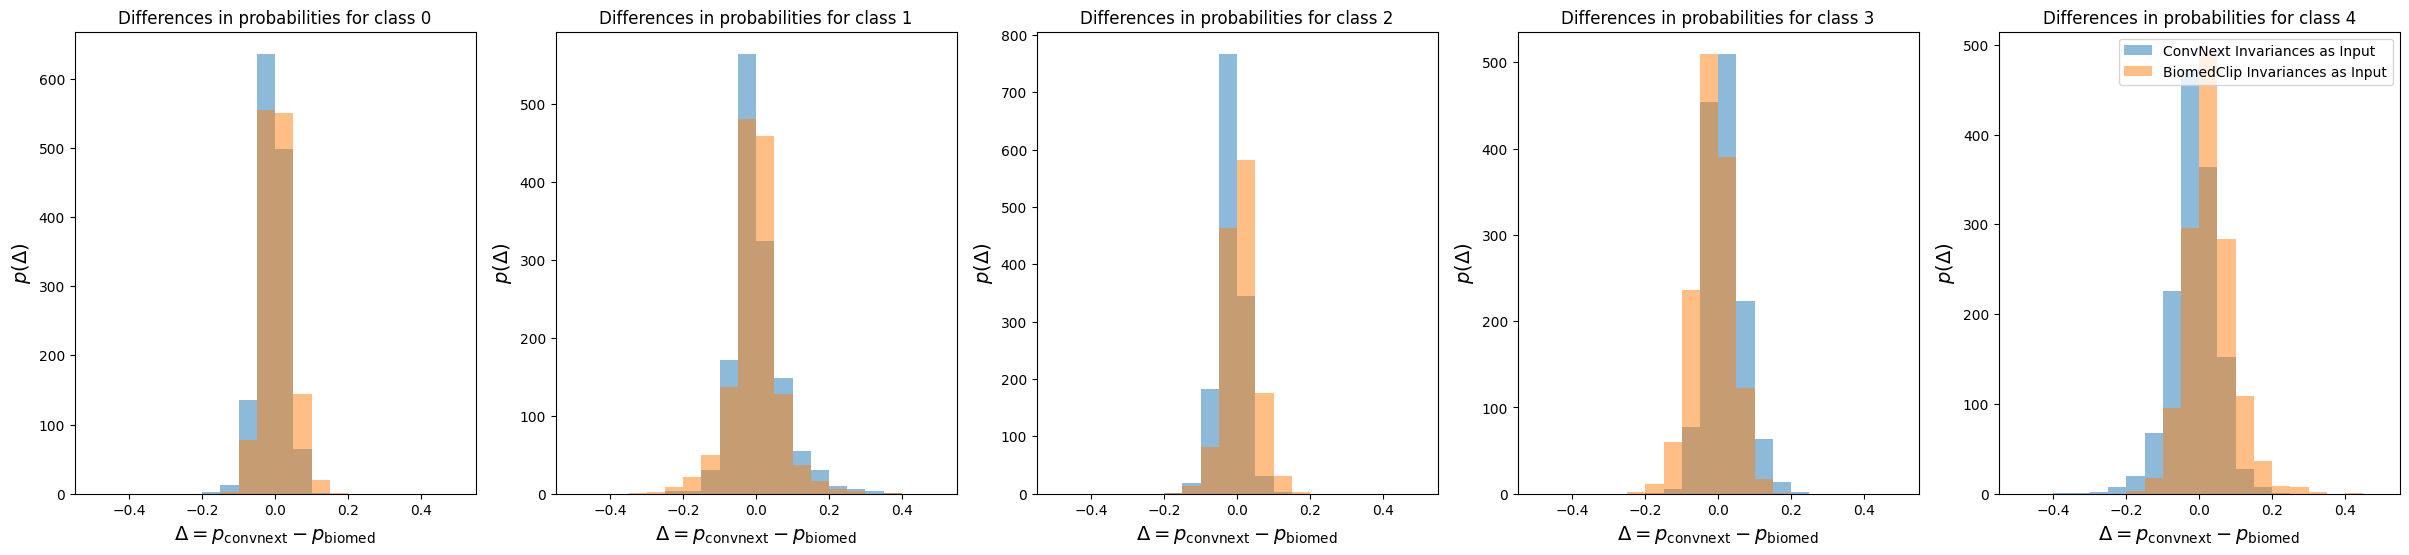

In [88]:
difference_convnext_embeddings = invariances_convnext_embeddings_calibrated.sigmoid() - invariances_convnext_cross_embeddings_calibrated.sigmoid()
difference_biomed_embeddings = invariances_biomed_cross_embeddings_calibrated.sigmoid() - invariances_biomed_embeddings_calibrated.sigmoid()
plt.figure(figsize=(6*difference_convnext_embeddings.shape[1], 6))
plt.tight_layout()
for i in range(difference_convnext_embeddings.shape[1]):
    plt.subplot(1, difference_convnext_embeddings.shape[1], i+1)
    plt.title(f"Differences in probabilities for class {i}")
    plt.hist(difference_convnext_embeddings[:,i].cpu().detach().numpy(), range=[-0.5, 0.5], bins=20, density=False, alpha=0.5, label="ConvNext Invariances as Input")
    plt.hist(difference_biomed_embeddings[:,i].cpu().detach().numpy(), range=[-0.5, 0.5], bins=20, density=False, alpha=0.5, label="BiomedClip Invariances as Input")
    plt.ylabel(r"$p(\Delta)$", fontsize=14)
    plt.xlabel(r"$\Delta = p_\text{convnext} - p_\text{biomed}$", fontsize=14)
plt.legend()
plt.show()

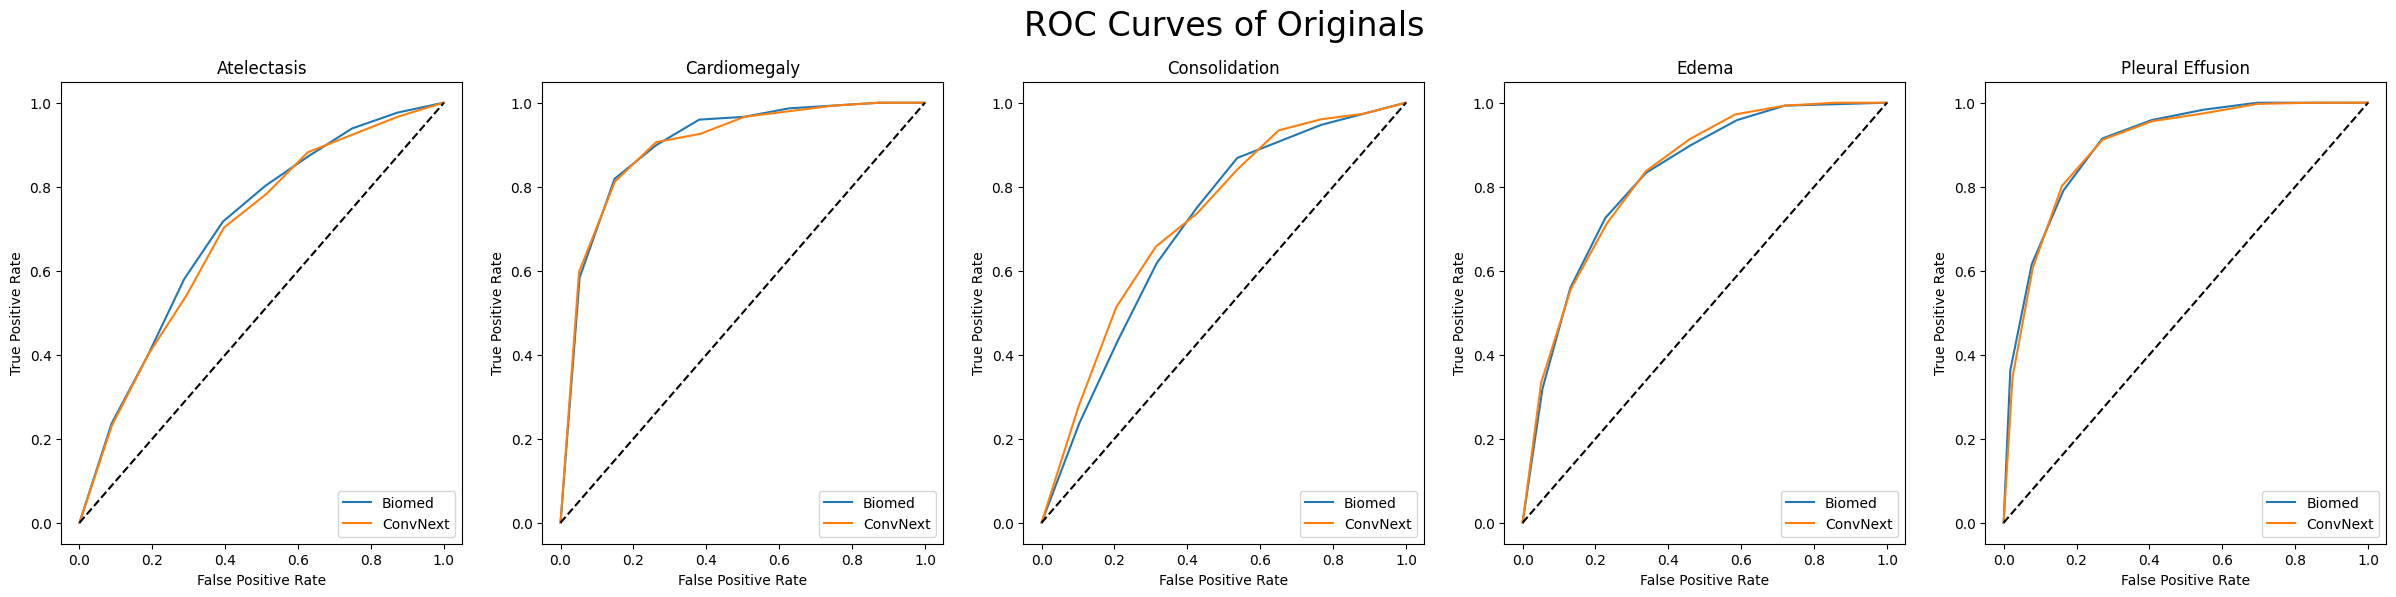

In [89]:
plt.figure(figsize=(6*original_convnext_embeddings_calibrated.shape[1], 6))
plt.tight_layout()
plt.title("ROC Curves of Originals\n", fontsize=24)
plt.axis("off")

for i in range(original_convnext_embeddings_calibrated.shape[1]):
    plt.subplot(1, original_convnext_embeddings_calibrated.shape[1], i+1)
    fpr, tpr = compute_ROC_curve(original_biomed_embeddings_calibrated[:,i], labels[:,i].bool())
    plt.plot(fpr.cpu().detach().numpy(), tpr.cpu().detach().numpy(), label="Biomed")
    fpr, tpr = compute_ROC_curve(original_convnext_embeddings_calibrated[:,i], labels[:,i].bool())
    plt.plot(fpr.cpu().detach().numpy(), tpr.cpu().detach().numpy(), label="ConvNext")
    plt.plot([0, 1], [0, 1], color="black", linestyle="--")
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc="lower right")
    plt.title(target_columns[i])
plt.show()

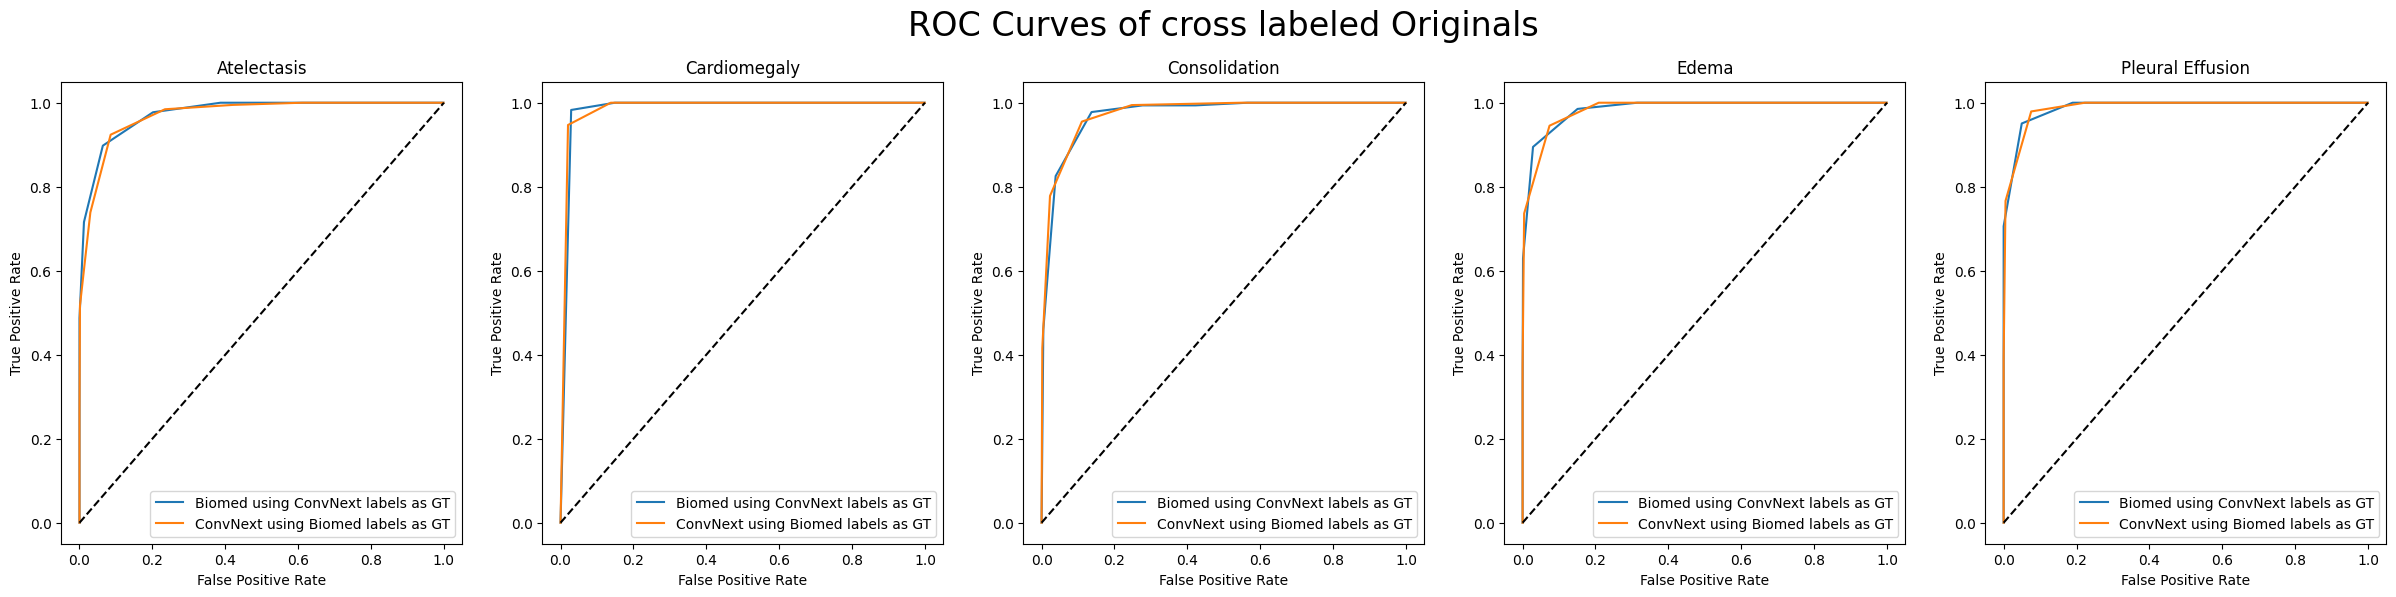

In [90]:
originals_labeled_by_convnext = original_convnext_embeddings_calibrated.sigmoid() > threshold_convnext
originals_labeled_by_biomed = original_biomed_embeddings_calibrated.sigmoid() > threshold_biomed
plt.figure(figsize=(6*original_convnext_embeddings.shape[1], 6))
plt.tight_layout()
plt.title("ROC Curves of cross labeled Originals\n", fontsize=24)
plt.axis("off")

for i in range(original_convnext_embeddings_calibrated.shape[1]):
    plt.subplot(1, original_convnext_embeddings_calibrated.shape[1], i+1)
    fpr, tpr = compute_ROC_curve(original_biomed_embeddings_calibrated[:,i], originals_labeled_by_convnext[:,i])
    plt.plot(fpr.cpu().detach().numpy(), tpr.cpu().detach().numpy(), label="Biomed using ConvNext labels as GT")
    fpr, tpr = compute_ROC_curve(original_convnext_embeddings_calibrated[:,i], originals_labeled_by_biomed[:,i])
    plt.plot(fpr.cpu().detach().numpy(), tpr.cpu().detach().numpy(), label="ConvNext using Biomed labels as GT")
    plt.plot([0, 1], [0, 1], color="black", linestyle="--")
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc="lower right")
    plt.title(target_columns[i])
plt.show()

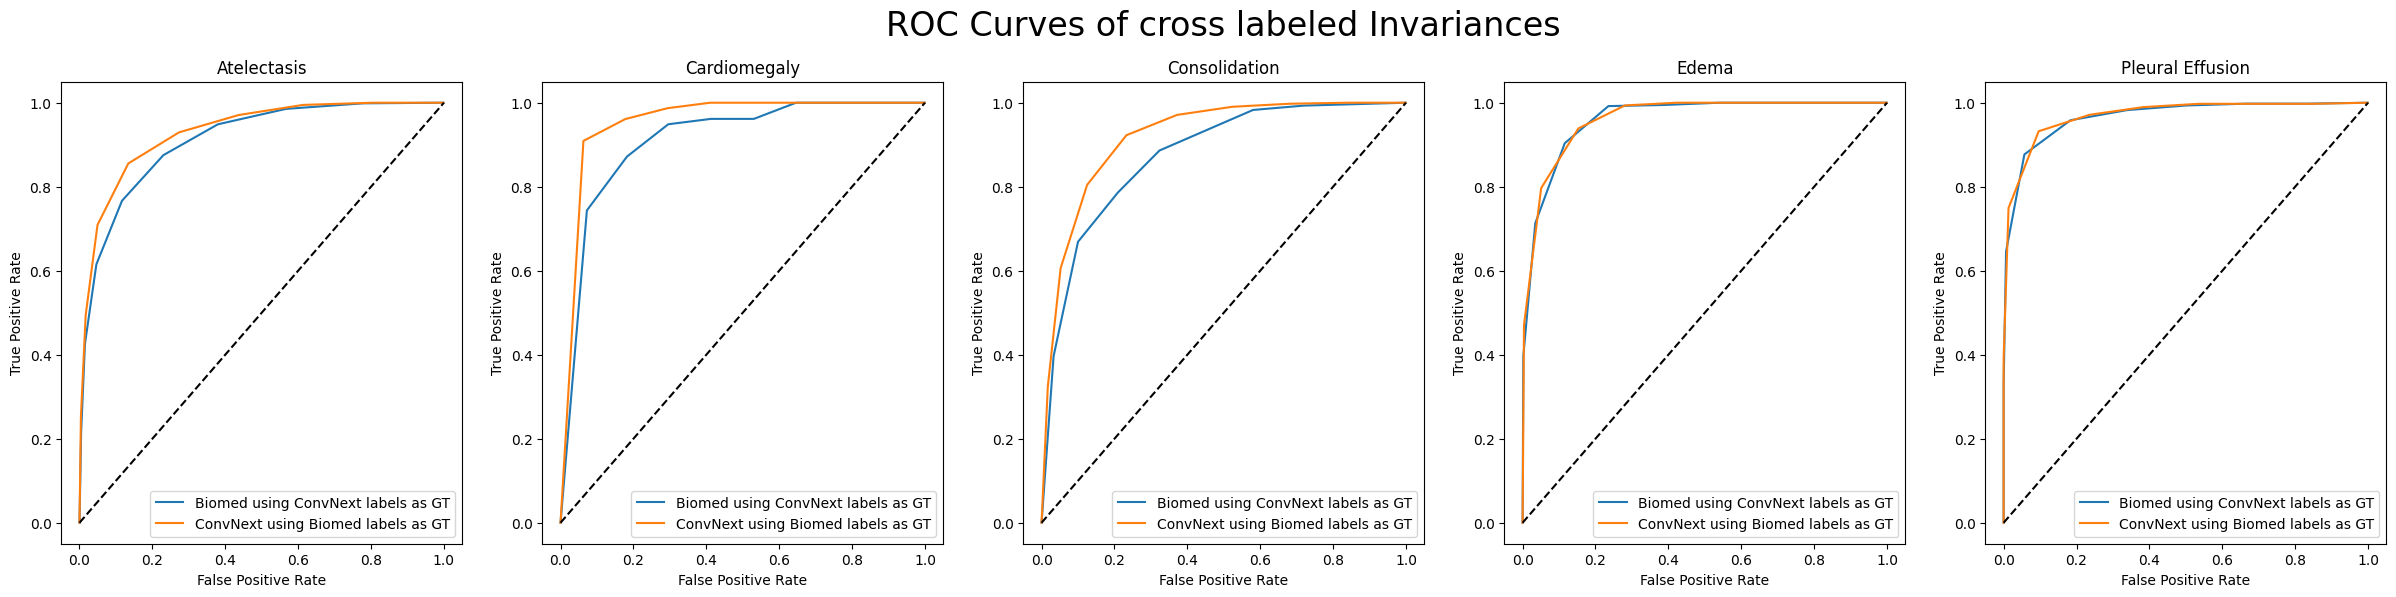

In [91]:
invariances_cross_labeled_by_convnext = invariances_biomed_cross_embeddings_calibrated.sigmoid() > threshold_convnext
invariances_cross_labeled_by_biomed = invariances_convnext_cross_embeddings_calibrated.sigmoid() > threshold_biomed
plt.figure(figsize=(6*invariances_biomed_embeddings.shape[1], 6))
plt.tight_layout()
plt.title("ROC Curves of cross labeled Invariances\n", fontsize=24)
plt.axis("off")

for i in range(invariances_biomed_embeddings_calibrated.shape[1]):
    plt.subplot(1, invariances_biomed_embeddings_calibrated.shape[1], i+1)
    fpr, tpr = compute_ROC_curve(invariances_biomed_embeddings_calibrated[:,i], invariances_cross_labeled_by_convnext[:,i])
    plt.plot(fpr.cpu().detach().numpy(), tpr.cpu().detach().numpy(), label="Biomed using ConvNext labels as GT")
    fpr, tpr = compute_ROC_curve(invariances_convnext_embeddings_calibrated[:,i], invariances_cross_labeled_by_biomed[:,i])
    plt.plot(fpr.cpu().detach().numpy(), tpr.cpu().detach().numpy(), label="ConvNext using Biomed labels as GT")
    plt.plot([0, 1], [0, 1], color="black", linestyle="--")
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc="lower right")
    plt.title(target_columns[i])
plt.show()

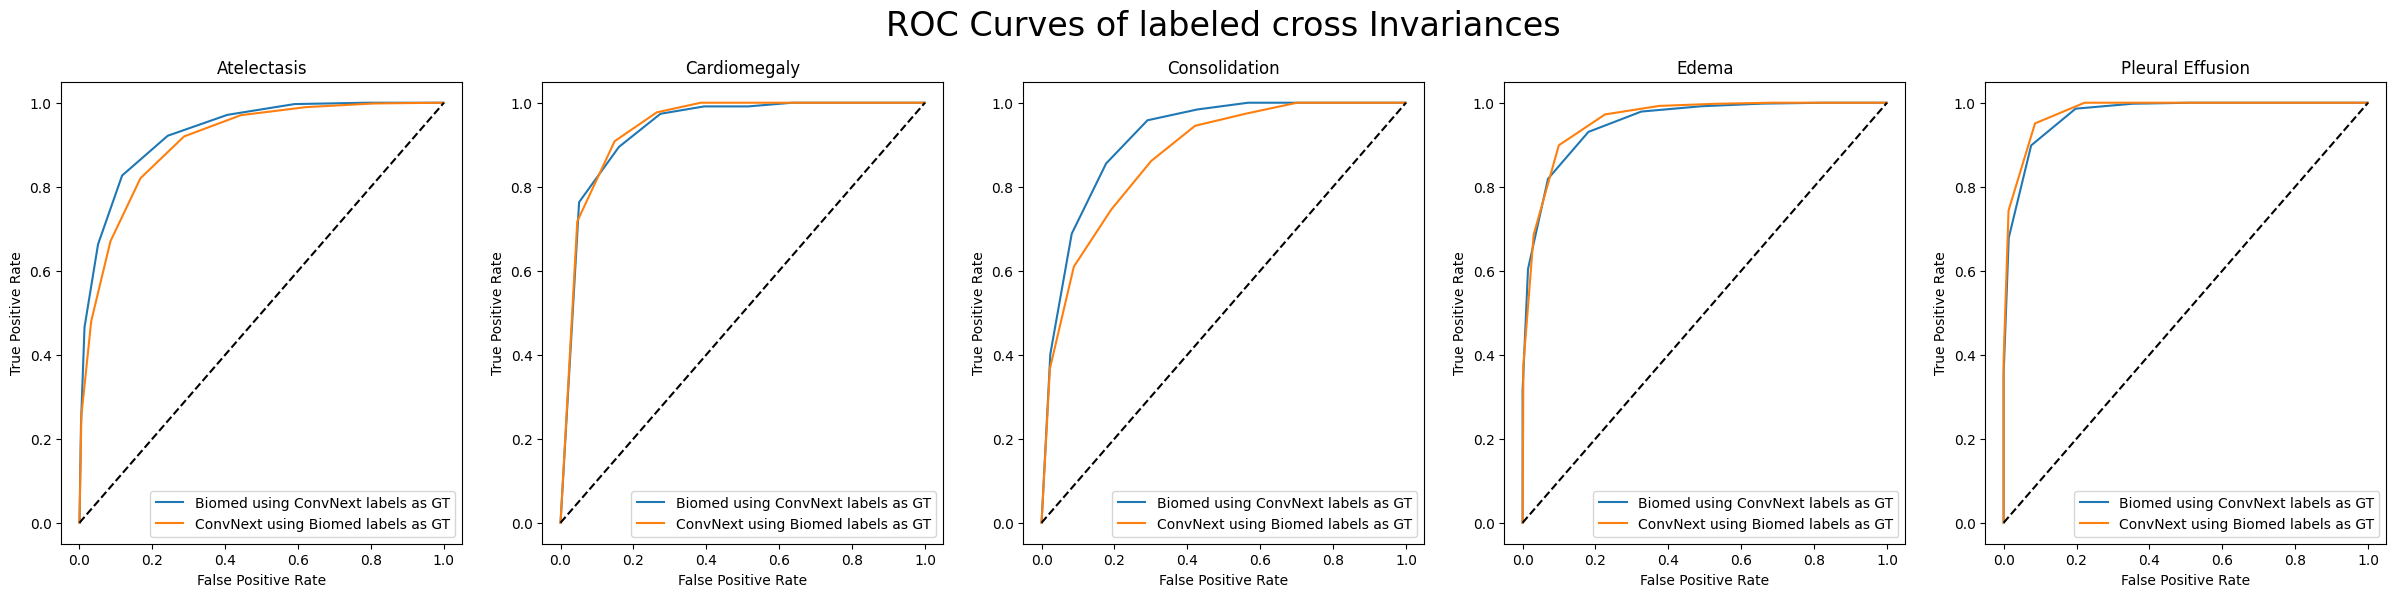

In [92]:
invariances_labeled_by_convnext = invariances_convnext_embeddings_calibrated.sigmoid() > threshold_convnext
invariances_labeled_by_biomed = invariances_biomed_embeddings_calibrated.sigmoid() > threshold_biomed
plt.figure(figsize=(6*invariances_biomed_embeddings.shape[1], 6))
plt.tight_layout()
plt.title("ROC Curves of labeled cross Invariances\n", fontsize=24)
plt.axis("off")

for i in range(invariances_biomed_embeddings_calibrated.shape[1]):
    plt.subplot(1, invariances_biomed_embeddings_calibrated.shape[1], i+1)
    fpr, tpr = compute_ROC_curve(invariances_convnext_cross_embeddings_calibrated[:,i], invariances_labeled_by_convnext[:,i])
    plt.plot(fpr.cpu().detach().numpy(), tpr.cpu().detach().numpy(), label="Biomed using ConvNext labels as GT")
    fpr, tpr = compute_ROC_curve(invariances_biomed_cross_embeddings_calibrated[:,i], invariances_labeled_by_biomed[:,i])
    plt.plot(fpr.cpu().detach().numpy(), tpr.cpu().detach().numpy(), label="ConvNext using Biomed labels as GT")
    plt.plot([0, 1], [0, 1], color="black", linestyle="--")
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc="lower right")
    plt.title(target_columns[i])
plt.show()

In [93]:
invariances_cross_labeled_by_convnext = invariances_biomed_cross_embeddings_calibrated.sigmoid() > threshold_convnext
invariances_labeled_by_biomed = invariances_biomed_embeddings_calibrated.sigmoid() > threshold_biomed
original_labeled_by_biomed = original_biomed_embeddings_calibrated.sigmoid() > threshold_convnext
biomed_correct = (original_biomed_embeddings_calibrated.sigmoid() > threshold_convnext).to(device) == labels.to(device)
class_ind = 1
no_disease_seen = torch.logical_and(biomed_correct[:,class_ind], labels.to(device)[:,class_ind]==0)
disease_overlooked = torch.logical_and(no_disease_seen, invariances_cross_labeled_by_convnext[:,class_ind])
disease_overlooked = torch.logical_and(disease_overlooked, invariances_labeled_by_biomed[:,class_ind]==0)
print(sum(disease_overlooked))

tensor(20, device='cuda:0')


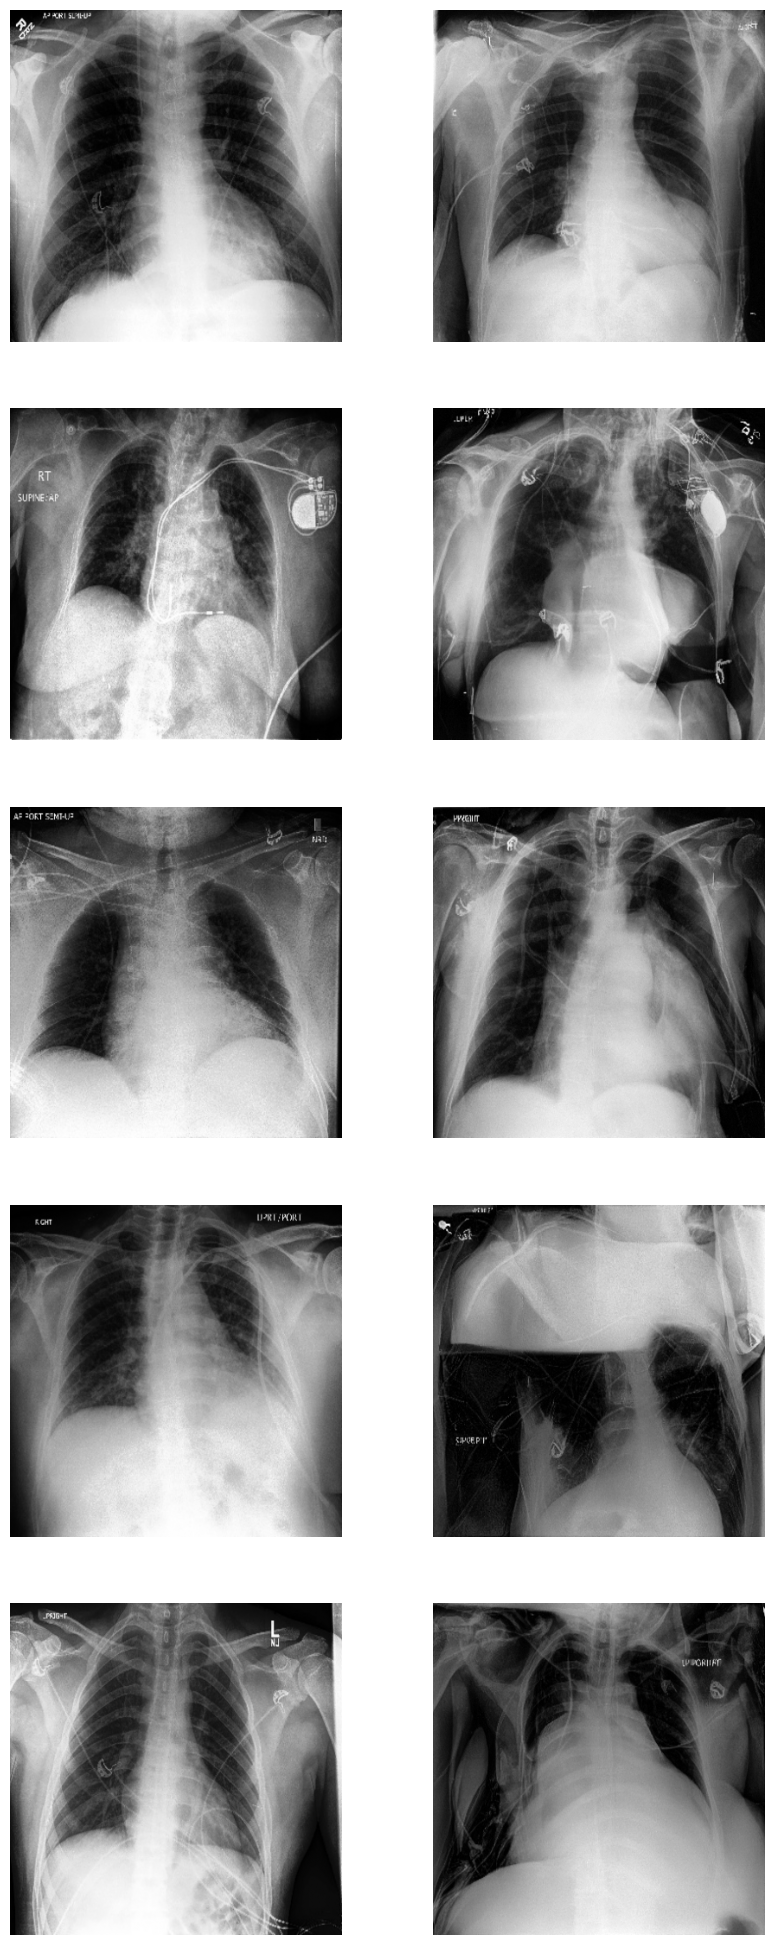

In [94]:
ind_disease_overlooked = torch.where(disease_overlooked)[0]
plt.figure(figsize=(10, 25))
for i, ind in enumerate(ind_disease_overlooked[torch.randperm(len(ind_disease_overlooked))[:5]]):
    plt.subplot(5, 2, i*2+1)
    plt.imshow(originals[ind].squeeze().cpu().detach().numpy(), cmap="gray")
    plt.axis("off")
    plt.subplot(5, 2, i*2+2)
    plt.imshow(invariances_biomed[ind].squeeze().cpu().detach().numpy(), cmap="gray")
    plt.axis("off")
plt.show()

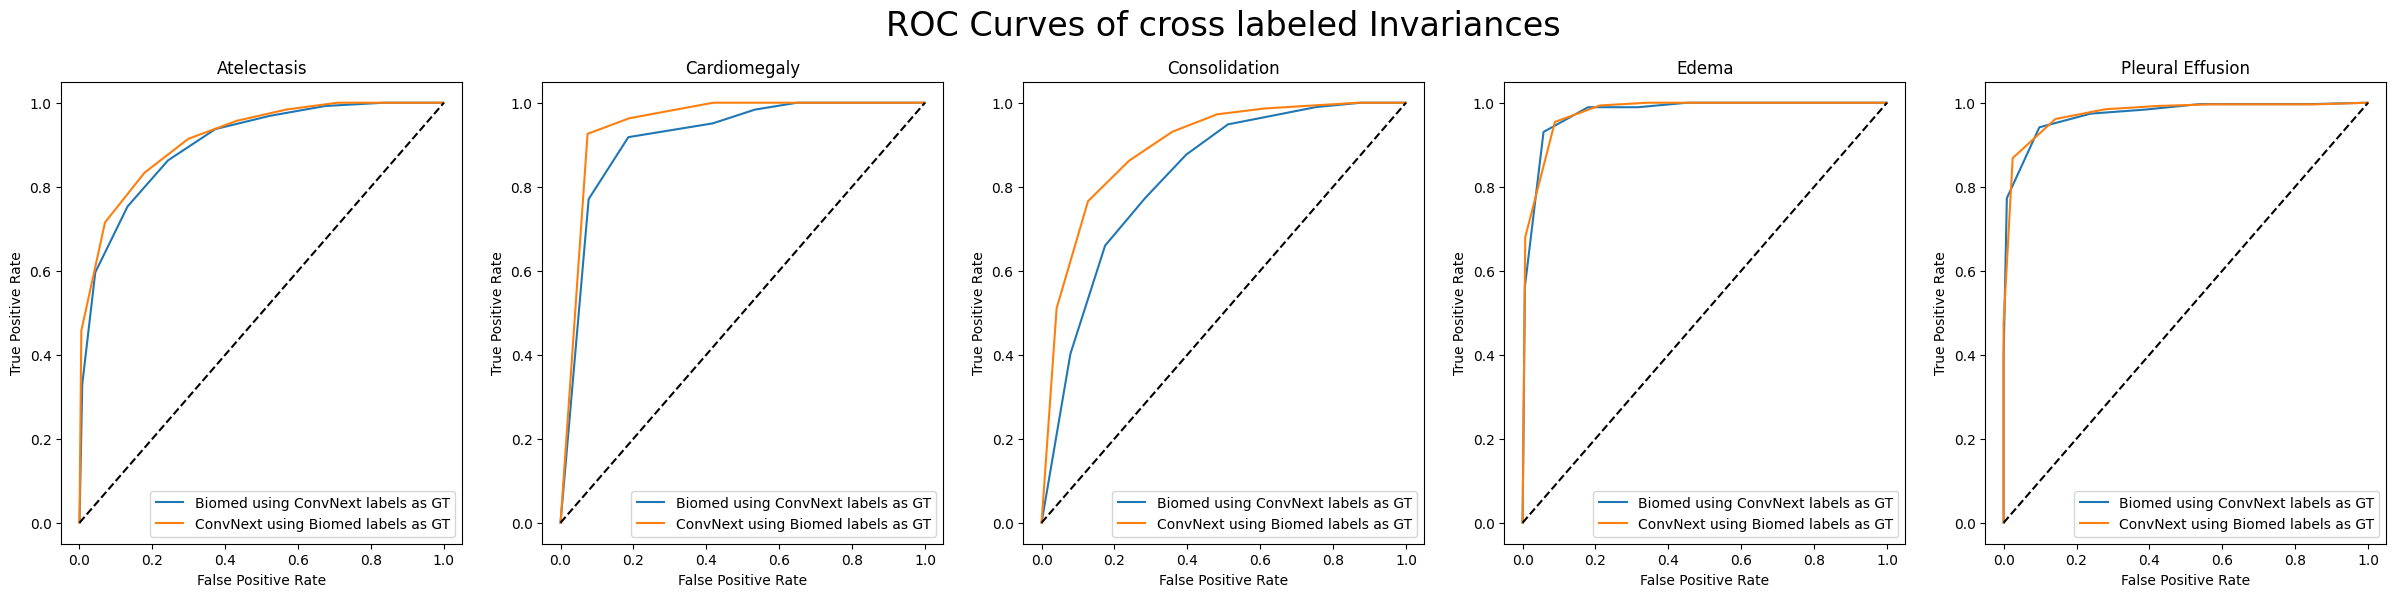

In [95]:
biomed_correct = (original_biomed_embeddings_calibrated.sigmoid() > threshold_biomed).to(device) == labels.to(device)
convnext_correct = (original_convnext_embeddings_calibrated.sigmoid() > threshold_convnext).to(device) == labels.to(device)

both_models_correct = torch.logical_and(biomed_correct, convnext_correct)

invariances_cross_labeled_by_convnext = invariances_biomed_cross_embeddings_calibrated.sigmoid() > threshold_convnext
invariances_cross_labeled_by_biomed = invariances_convnext_cross_embeddings_calibrated.sigmoid() > threshold_biomed


plt.figure(figsize=(6*invariances_biomed_embeddings.shape[1], 6))
plt.tight_layout()
plt.title("ROC Curves of cross labeled Invariances\n", fontsize=24)
plt.axis("off")

agreement_on_biomed_invariances = torch.zeros(5)
agreement_on_convnext_invariances = torch.zeros(5)
agreement_on_originals = ((original_biomed_embeddings_calibrated.sigmoid() > threshold_biomed) == (original_convnext_embeddings_calibrated.sigmoid() > threshold_convnext)).float().mean(dim=0)


for i in range(invariances_biomed_embeddings_calibrated.shape[1]):
    plt.subplot(1, invariances_biomed_embeddings_calibrated.shape[1], i+1)
    fpr, tpr = compute_ROC_curve(invariances_biomed_embeddings_calibrated[both_models_correct[:, i],i], invariances_cross_labeled_by_convnext[both_models_correct[:, i],i])
    aurocs["biomed_cross_agreement"][i] = torch.trapz(tpr, fpr)
    agreement_on_biomed_invariances[i] = (invariances_cross_labeled_by_convnext[both_models_correct[:, i],i] == labels.to(device)[both_models_correct[:, i],i]).float().mean()
    plt.plot(fpr.cpu().detach().numpy(), tpr.cpu().detach().numpy(), label="Biomed using ConvNext labels as GT")    

    
    fpr, tpr = compute_ROC_curve(invariances_convnext_embeddings_calibrated[both_models_correct[:, i],i], invariances_cross_labeled_by_biomed[both_models_correct[:, i],i])
    aurocs["convnext_cross_agreement"][i] = torch.trapz(tpr, fpr)
    agreement_on_convnext_invariances[i] = (invariances_cross_labeled_by_biomed[both_models_correct[:, i],i] == labels.to(device)[both_models_correct[:, i],i]).float().mean()
    plt.plot(fpr.cpu().detach().numpy(), tpr.cpu().detach().numpy(), label="ConvNext using Biomed labels as GT")
    plt.plot([0, 1], [0, 1], color="black", linestyle="--")
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc="lower right")
    plt.title(target_columns[i])
plt.show()

In [96]:
print(agreement_on_biomed_invariances)
print(agreement_on_convnext_invariances)
print(agreement_on_originals)

print(agreement_on_biomed_invariances.mean())
print(agreement_on_convnext_invariances.mean())
print(agreement_on_originals.mean())

tensor([0.8181, 0.9544, 0.9123, 0.9433, 0.9429])
tensor([0.8880, 0.9682, 0.8834, 0.9413, 0.9447])
tensor([0.9141, 0.9807, 0.9267, 0.9252, 0.9541], device='cuda:0')
tensor(0.9142)
tensor(0.9251)
tensor(0.9401, device='cuda:0')


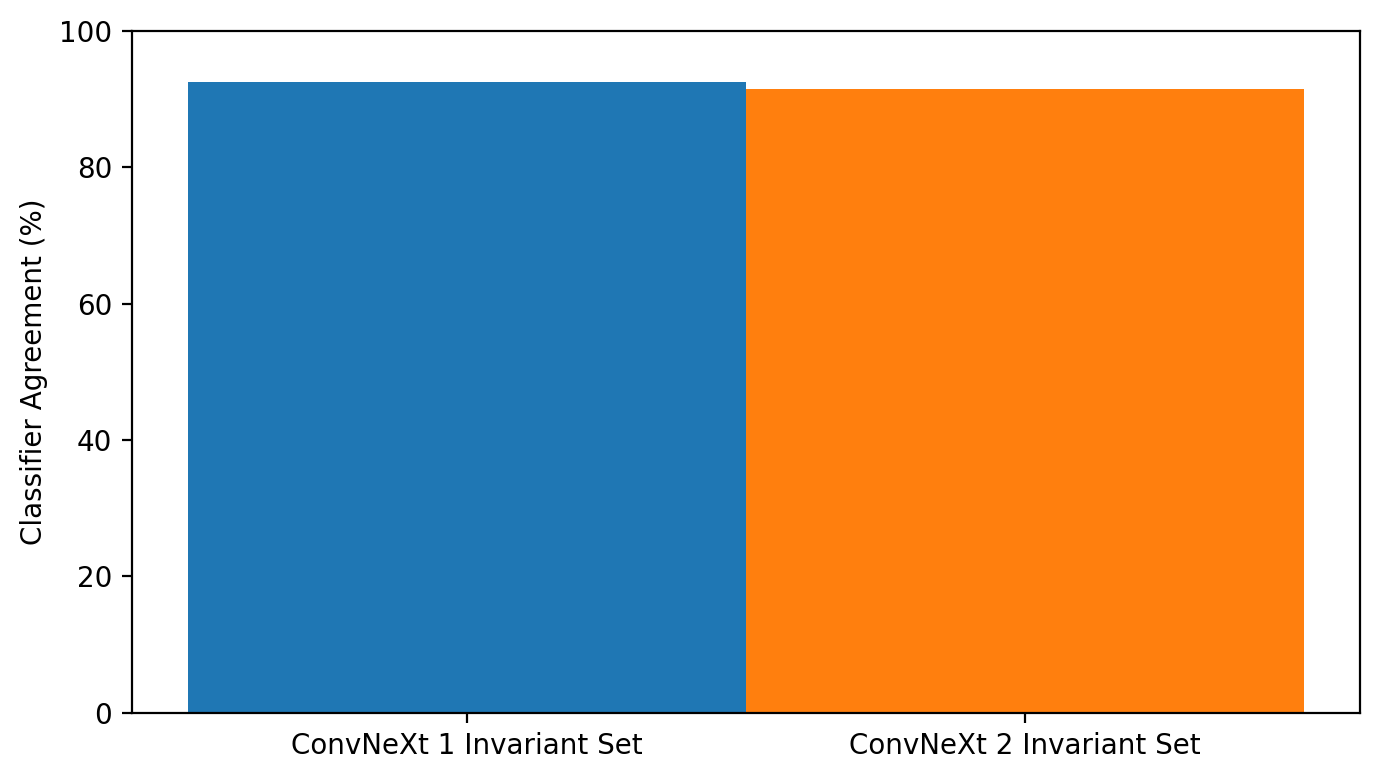

In [98]:
agreement_marg_orig = agreement_on_originals.mean().item()
agreement_marg_convnext = agreement_on_convnext_invariances.mean().item()*100
agreement_marg_biomed = agreement_on_biomed_invariances.mean().item()*100

labels = ["ConvNeXt 1 Invariant Set", "ConvNeXt 2 Invariant Set"]
x = np.arange(len(labels))
width = 1

plt.figure(figsize=(7, 4), dpi=200)

plt.bar(
    x,
    [agreement_marg_convnext, agreement_marg_biomed],
    width,
    color=["C0", "C1"],
    capsize=4,
)


plt.xticks(x, labels)
plt.ylabel("Classifier Agreement (%)")
plt.ylim(0, 100)
plt.tight_layout()
plt.show()


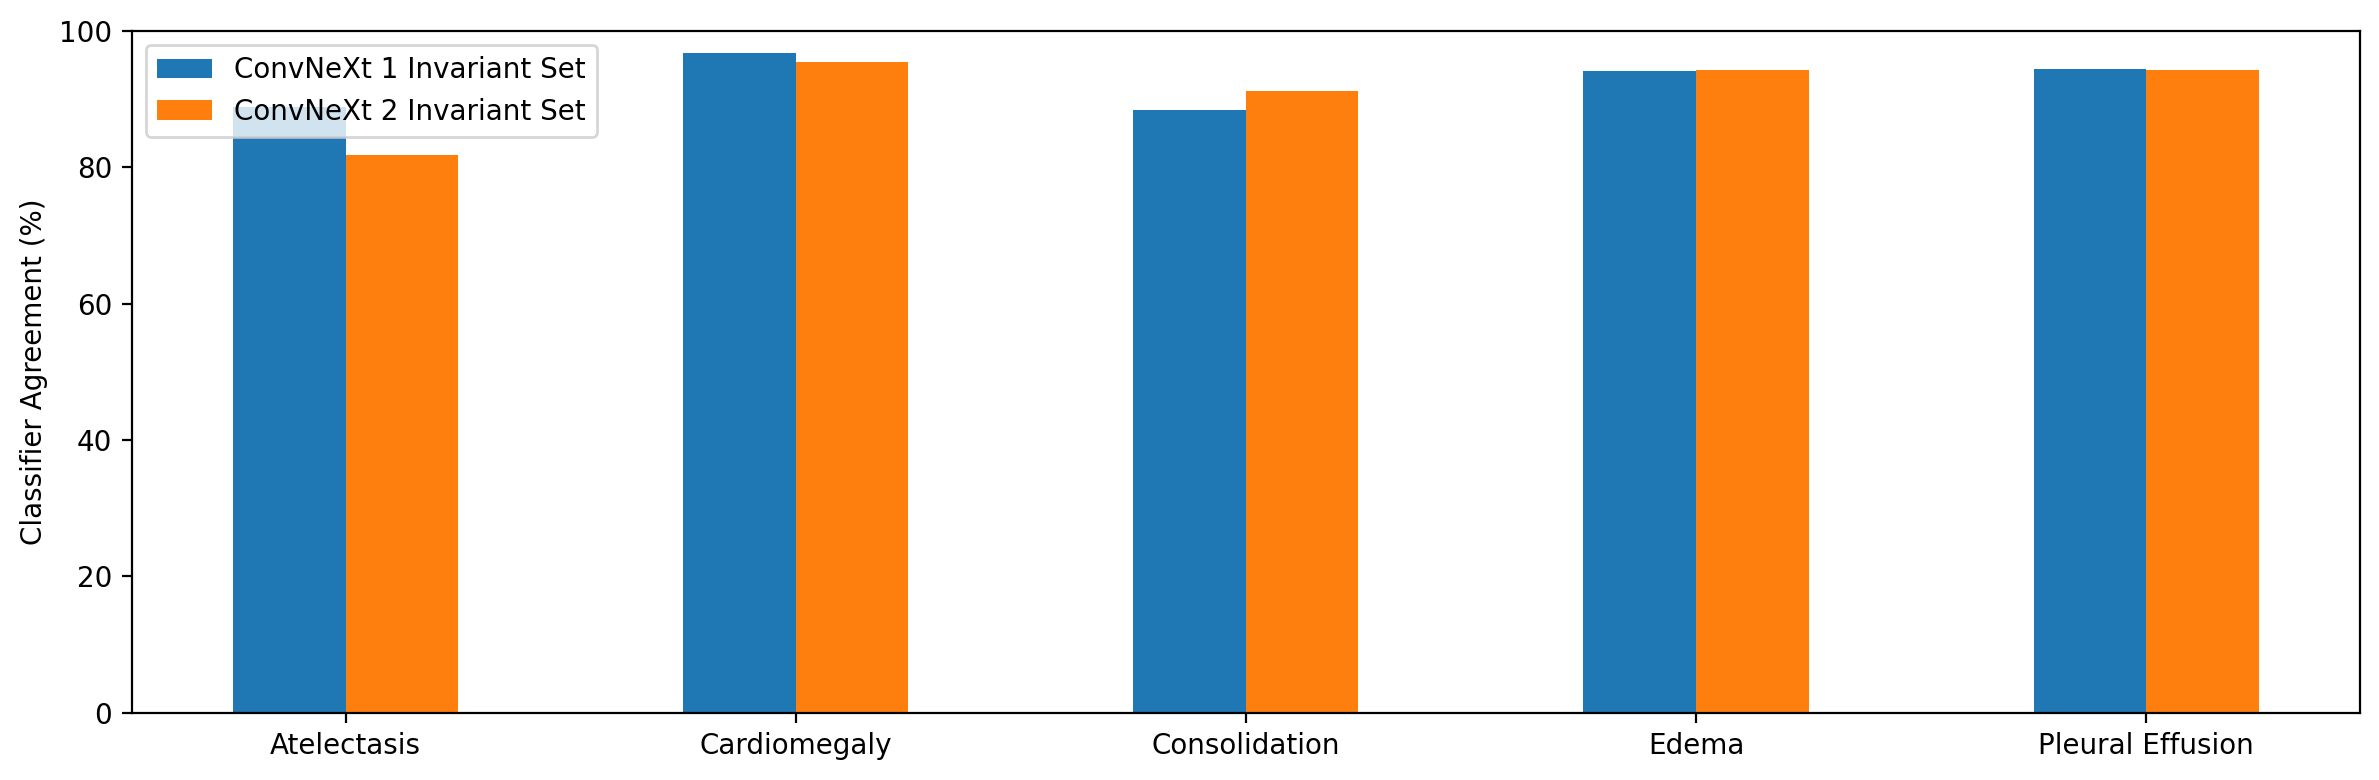

In [99]:
labels = target_columns
x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(12, 4), dpi=200)

# plt.bar(
#     x - width,
#     agreement_on_originals.cpu().detach().numpy()*100,
#     width,
#     label="Original Samples",
#     capsize=4,
# )

plt.bar(
    x - width/2,
    agreement_on_convnext_invariances.cpu().detach().numpy()*100,
    width,
    label="ConvNeXt 1 Invariant Set",
    capsize=4,
)

plt.bar(
    x + width/2,
    agreement_on_biomed_invariances.cpu().detach().numpy()*100,
    width,
    label="ConvNeXt 2 Invariant Set",
    capsize=4,
)


plt.xticks(x, labels)
plt.ylabel("Classifier Agreement (%)")
plt.ylim(0, 100)
plt.legend()
plt.tight_layout()
plt.show()